In [1]:
import anndata
import celloracle as co
import dynamo as dyn
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import pickle
import random
import scipy as scp
from scipy import sparse
from scipy.integrate import solve_ivp
import scipy.interpolate as interp
from scipy.signal import convolve2d
from scipy.spatial.distance import squareform
import scHopfield as sch
import seaborn as sns
import sys
from tqdm import tqdm

which: no R in (/opt/slurm/puppet/bin:/opt/slurm/cluster/ibex/install-v2/RedHat-9/bin:/opt/slurm/scripts/bin:/usr/lpp/mmfs/bin:/home/bernaljp/miniconda3/envs/SCH/bin:/opt/slurm/puppet/bin:/opt/slurm/cluster/ibex/install-v2/RedHat-9/bin:/opt/slurm/scripts/bin:/usr/lpp/mmfs/bin:/home/bernaljp/miniconda3/condabin:/opt/slurm/puppet/bin:/usr/share/Modules/bin:/opt/slurm/cluster/ibex/install-v2/RedHat-9/bin:/opt/slurm/scripts/bin:/usr/lpp/mmfs/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/slurm/scripts/bin:/opt/puppetlabs/bin:/home/bernaljp/.local/bin:/home/bernaljp/bin:/opt/slurm/scripts/bin:/home/bernaljp/.local/bin:/home/bernaljp/bin:/opt/slurm/scripts/bin:/home/bernaljp/.local/bin:/home/bernaljp/bin)
/home/bernaljp/miniconda3/envs/SCH/lib/python3.11/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrai

In [2]:
%matplotlib inline

In [3]:
os.listdir(".")

['data',
 'figures',
 'out',
 'dcgm',
 'jupyter-server-cpu-04h.sh',
 'jupyter-server-cpu-n_hours.sh',
 'jupyter-server-gpu-04h.sh',
 'jupyter-server-gpu-n_hours.sh',
 'spatial_vae_run1',
 'mygene_cache',
 'spatial_vae_gencode']

In [4]:
# Data configuration
DATA_PATH = '/home/bernaljp/scratch/Data/'  # Update this path
DATASET_NAME = 'Hematopoiesis'
DATASET_FILE = 'hematopoiesis.h5ad'  # Update filename

# Analysis parameters
CLUSTER_KEY = 'cell_type'  # Update to your cluster column name
VELOCITY_KEY = 'velocity_alpha_minus_gamma_s'
SPLICED_KEY = 'M_t'
DEGRADATION_KEY = 'gamma'
DYNAMIC_GENES_KEY = 'use_for_dynamics'

# Order for plotting (update with your cell types)
CELL_TYPE_ORDER = ['HSC', 'MEP-like', 'Ery', 'Meg', 'GMP-like', 'Mon', 'Neu', 'Bas']

# Network inference parameters
N_EPOCHS = 1000
BATCH_SIZE = 128
W_THRESHOLD = 1e-12
SCAFFOLD_REGULARIZATION = 1e-2
DEVICE = 'cuda'  # or 'cpu'

# Visualization parameters
FIGSIZE_LARGE = (15, 10)
FIGSIZE_MEDIUM = (10, 6)

## 1. Load and Preprocess Data

In [5]:
print("\n1. Loading data...")
adata = dyn.read_h5ad(DATA_PATH + DATASET_FILE)
print(f"   Loaded: {adata.n_obs} cells × {adata.n_vars} genes")

# Remove genes with NaN velocities (Hematopoiesis-specific)
if DATASET_NAME == 'Hematopoiesis':
    print("   Removing genes with NaN velocities...")
    bad_genes = np.unique(np.where(np.isnan(adata.layers[VELOCITY_KEY].toarray()))[1])
    adata = adata[:, ~np.isin(range(adata.n_vars), bad_genes)]
    print(f"   After filtering: {adata.n_obs} cells × {adata.n_vars} genes")

# Get genes to use for analysis
genes_to_use = adata.var[DYNAMIC_GENES_KEY].values
n_genes = genes_to_use.sum()
print(f"   Using {n_genes} dynamic genes for analysis")


1. Loading data...
   Loaded: 1947 cells × 1956 genes
   Removing genes with NaN velocities...
   After filtering: 1947 cells × 1728 genes
   Using 1728 dynamic genes for analysis


|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_type by stack threshold when stacking color because it is not a numeric type


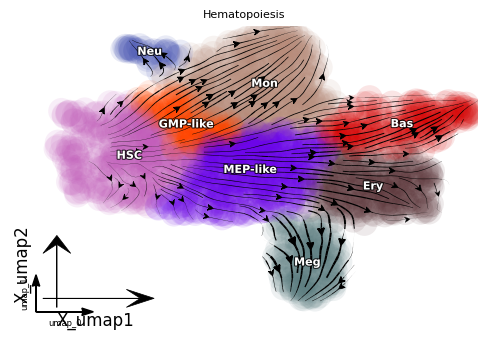

In [6]:
# %%
ax = dyn.pl.streamline_plot(adata, color=CLUSTER_KEY, basis="umap", show_legend="on data", show_arrowed_spines=True, size=(15,10), save_show_or_return='return')
ax[0].set_title("Hematopoiesis")
plt.show()

# %%
colors = {k:ax[0].get_children()[0]._facecolors[np.where(adata.obs[CLUSTER_KEY]==k)[0][0]] for k in adata.obs[CLUSTER_KEY].unique()}
for k in colors:
    colors[k][3] = 1

## 2. Load Scaffold from CellOracle

In [7]:
print("\n2. Loading CellOracle scaffold...")
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()
base_GRN.drop(['peak_id'], axis=1, inplace=True)

# Create scaffold matrix
scaffold = pd.DataFrame(
    0,
    index=adata.var.index[genes_to_use],
    columns=adata.var.index[genes_to_use]
)

# Convert gene names to lowercase for case-insensitive comparison
tfs = list(set(base_GRN.columns.str.lower()) & set(scaffold.index.str.lower()))
target_genes = list(set(base_GRN['gene_short_name'].str.lower().values) & set(scaffold.columns.str.lower()))

# Map original names for assignment
index_map = {gene.lower(): gene for gene in scaffold.index}
col_map = {gene.lower(): gene for gene in scaffold.columns}

# Fill scaffold with 1s where connections exist
for tf in tfs:
    tf_original = index_map[tf]
    tf_base_GRN = [col for col in base_GRN.columns if col.lower() == tf][0]

    for target in base_GRN[base_GRN[tf_base_GRN] == 1]['gene_short_name']:
        if target.lower() in target_genes:
            target_original = col_map[target.lower()]
            scaffold.loc[tf_original, target_original] = 1

print(f"   Scaffold created: {scaffold.sum().sum()} potential connections")
print(f"   TFs: {len(tfs)}, Target genes: {len(target_genes)}")


2. Loading CellOracle scaffold...
   Scaffold created: 41693 potential connections
   TFs: 73, Target genes: 1148


In [8]:
sch.pp.fit_all_sigmoids(adata,
                         spliced_key=SPLICED_KEY,
                         genes=adata.var['use_for_dynamics'].values)

sch.pp.compute_sigmoid(adata, spliced_key=SPLICED_KEY, copy=False)

/home/bernaljp/packages/scHopfield/scHopfield/_utils/math.py:93: RuntimeWarning: divide by zero encountered in divide
  ty = np.log(y / (1 - y))
/home/bernaljp/packages/scHopfield/scHopfield/_utils/math.py:93: RuntimeWarning: divide by zero encountered in log
  ty = np.log(y / (1 - y))


In [9]:
adata

AnnData object with n_obs × n_vars = 1947 × 1728
    obs: 'batch', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase', 'leiden', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'pca_ddhodge_div', 'pca_ddhodge_potential', 'acceleration_pca', 'curvature_pca', 'n_counts', 'mt_frac', 'jacobian_det_pca', 'manual_selection', 'divergence_pca', 'curv_leiden', 'curv_louvain', 'SPI1->GATA1_jacobian', 'jacobian', 'umap_ori_leiden', 'umap_ori_louvain', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'acceleration_umap', 'control_point_umap_ori', 'inlier_prob_umap_ori', 'obs_vf_angle_umap_ori', 'curvature_umap_ori'
    var: 'gene_name', 'gene_id', 'nCells', 'nCounts', 'pass_basic

In [10]:
sch.inf.fit_interactions(adata,
                         cluster_key=CLUSTER_KEY,
                         spliced_key=SPLICED_KEY,
                         velocity_key=VELOCITY_KEY,
                         degradation_key=DEGRADATION_KEY,
                         w_threshold=1e-12,
                         w_scaffold=scaffold.values,
                         scaffold_regularization=1e-2,
                         only_TFs=True,
                         infer_I=True,
                         refit_gamma=False,
                         pre_initialize_W=False,
                         n_epochs=1000,
                         criterion='MSE',
                         batch_size=128,
                         skip_all=True,
                         use_scheduler=True,
                         get_plots=False,
                         device='cuda')

Inferring interaction matrix W and bias vector I for cluster Mon


/home/bernaljp/packages/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))
Training Epochs:   1%|▏         | 14/1000 [00:01<01:05, 15.15it/s]

[Epoch 1/1000] Total Loss: 1509.638840, Reconstruction Loss: 9.597438, Batch size: 39


Training Epochs:  12%|█▏        | 121/1000 [00:02<00:07, 113.79it/s]

[Epoch 101/1000] Total Loss: 594.980484, Reconstruction Loss: 0.069478, Batch size: 39


Training Epochs:  22%|██▏       | 218/1000 [00:02<00:06, 128.62it/s]

[Epoch 201/1000] Total Loss: 484.191849, Reconstruction Loss: 0.014637, Batch size: 39


Training Epochs:  32%|███▏      | 316/1000 [00:03<00:05, 129.95it/s]

[Epoch 301/1000] Total Loss: 443.189247, Reconstruction Loss: 0.002955, Batch size: 39


Training Epochs:  41%|████▏     | 414/1000 [00:04<00:04, 129.85it/s]

[Epoch 401/1000] Total Loss: 426.928207, Reconstruction Loss: 0.001475, Batch size: 39


Training Epochs:  53%|█████▎    | 526/1000 [00:05<00:03, 130.04it/s]

[Epoch 501/1000] Total Loss: 420.199753, Reconstruction Loss: 0.001288, Batch size: 39


Training Epochs:  62%|██████▏   | 623/1000 [00:05<00:02, 129.19it/s]

[Epoch 601/1000] Total Loss: 417.501465, Reconstruction Loss: 0.001306, Batch size: 39


Training Epochs:  71%|███████▏  | 714/1000 [00:06<00:02, 124.48it/s]

[Epoch 701/1000] Total Loss: 416.415787, Reconstruction Loss: 0.001328, Batch size: 39


Training Epochs:  82%|████████▏ | 821/1000 [00:07<00:01, 129.18it/s]

[Epoch 801/1000] Total Loss: 415.982559, Reconstruction Loss: 0.001309, Batch size: 39


Training Epochs:  92%|█████████▏| 915/1000 [00:08<00:00, 130.07it/s]

[Epoch 901/1000] Total Loss: 415.808815, Reconstruction Loss: 0.001365, Batch size: 39


Training Epochs: 100%|██████████| 1000/1000 [00:08<00:00, 112.75it/s]
/home/bernaljp/packages/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))


[Epoch 1000/1000] Total Loss: 415.750511, Reconstruction Loss: 0.001322, Batch size: 39
Inferring interaction matrix W and bias vector I for cluster Meg


Training Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

[Epoch 1/1000] Total Loss: 1424.592346, Reconstruction Loss: 18.943429, Batch size: 26


Training Epochs:  14%|█▍        | 141/1000 [00:00<00:03, 278.17it/s]

[Epoch 101/1000] Total Loss: 631.786774, Reconstruction Loss: 0.122868, Batch size: 26


Training Epochs:  26%|██▌       | 256/1000 [00:00<00:02, 279.58it/s]

[Epoch 201/1000] Total Loss: 500.893845, Reconstruction Loss: 0.020708, Batch size: 26


Training Epochs:  34%|███▍      | 341/1000 [00:01<00:02, 279.34it/s]

[Epoch 301/1000] Total Loss: 449.438431, Reconstruction Loss: 0.007821, Batch size: 26


Training Epochs:  46%|████▌     | 457/1000 [00:01<00:01, 279.94it/s]

[Epoch 401/1000] Total Loss: 429.239288, Reconstruction Loss: 0.006559, Batch size: 26


Training Epochs:  54%|█████▍    | 542/1000 [00:01<00:01, 279.68it/s]

[Epoch 501/1000] Total Loss: 421.122559, Reconstruction Loss: 0.006584, Batch size: 26


Training Epochs:  63%|██████▎   | 629/1000 [00:02<00:01, 279.76it/s]

[Epoch 601/1000] Total Loss: 417.853119, Reconstruction Loss: 0.006918, Batch size: 26


Training Epochs:  74%|███████▍  | 745/1000 [00:02<00:00, 279.96it/s]

[Epoch 701/1000] Total Loss: 416.560913, Reconstruction Loss: 0.006680, Batch size: 26


Training Epochs:  83%|████████▎ | 832/1000 [00:02<00:00, 280.09it/s]

[Epoch 801/1000] Total Loss: 416.044510, Reconstruction Loss: 0.006718, Batch size: 26


Training Epochs:  95%|█████████▍| 947/1000 [00:03<00:00, 277.42it/s]

[Epoch 901/1000] Total Loss: 415.836685, Reconstruction Loss: 0.006693, Batch size: 26


Training Epochs: 100%|██████████| 1000/1000 [00:03<00:00, 278.64it/s]
/home/bernaljp/packages/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))


[Epoch 1000/1000] Total Loss: 415.756714, Reconstruction Loss: 0.006514, Batch size: 26
Inferring interaction matrix W and bias vector I for cluster MEP-like


Training Epochs:   1%|▏         | 13/1000 [00:00<00:08, 122.71it/s]

[Epoch 1/1000] Total Loss: 1504.292786, Reconstruction Loss: 5.838317, Batch size: 73


Training Epochs:  12%|█▏        | 117/1000 [00:00<00:07, 125.26it/s]

[Epoch 101/1000] Total Loss: 595.393463, Reconstruction Loss: 0.044227, Batch size: 73


Training Epochs:  22%|██▏       | 221/1000 [00:01<00:06, 126.17it/s]

[Epoch 201/1000] Total Loss: 483.867134, Reconstruction Loss: 0.010114, Batch size: 73


Training Epochs:  32%|███▎      | 325/1000 [00:02<00:05, 126.76it/s]

[Epoch 301/1000] Total Loss: 443.544151, Reconstruction Loss: 0.001865, Batch size: 73


Training Epochs:  42%|████▏     | 416/1000 [00:03<00:04, 126.83it/s]

[Epoch 401/1000] Total Loss: 426.953247, Reconstruction Loss: 0.000934, Batch size: 73


Training Epochs:  52%|█████▏    | 520/1000 [00:04<00:03, 126.95it/s]

[Epoch 501/1000] Total Loss: 420.218887, Reconstruction Loss: 0.000852, Batch size: 73


Training Epochs:  62%|██████▏   | 624/1000 [00:04<00:02, 126.79it/s]

[Epoch 601/1000] Total Loss: 417.510284, Reconstruction Loss: 0.000852, Batch size: 73


Training Epochs:  72%|███████▏  | 715/1000 [00:05<00:02, 127.00it/s]

[Epoch 701/1000] Total Loss: 416.421432, Reconstruction Loss: 0.000859, Batch size: 73


Training Epochs:  82%|████████▏ | 819/1000 [00:06<00:01, 126.93it/s]

[Epoch 801/1000] Total Loss: 415.983978, Reconstruction Loss: 0.000866, Batch size: 73


Training Epochs:  92%|█████████▏| 923/1000 [00:07<00:00, 127.93it/s]

[Epoch 901/1000] Total Loss: 415.809250, Reconstruction Loss: 0.000868, Batch size: 73


Training Epochs: 100%|██████████| 1000/1000 [00:07<00:00, 126.63it/s]
/home/bernaljp/packages/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))


[Epoch 1000/1000] Total Loss: 415.750443, Reconstruction Loss: 0.000868, Batch size: 73
Inferring interaction matrix W and bias vector I for cluster Ery


Training Epochs:   2%|▎         | 25/1000 [00:00<00:03, 243.95it/s]

[Epoch 1/1000] Total Loss: 1420.066223, Reconstruction Loss: 14.226508, Batch size: 106


Training Epochs:  13%|█▎        | 126/1000 [00:00<00:03, 248.74it/s]

[Epoch 101/1000] Total Loss: 627.530853, Reconstruction Loss: 0.108867, Batch size: 106


Training Epochs:  23%|██▎       | 228/1000 [00:00<00:03, 249.17it/s]

[Epoch 201/1000] Total Loss: 499.684784, Reconstruction Loss: 0.015385, Batch size: 106


Training Epochs:  33%|███▎      | 330/1000 [00:01<00:02, 249.53it/s]

[Epoch 301/1000] Total Loss: 449.364761, Reconstruction Loss: 0.003705, Batch size: 106


Training Epochs:  43%|████▎     | 430/1000 [00:01<00:02, 248.99it/s]

[Epoch 401/1000] Total Loss: 429.226334, Reconstruction Loss: 0.002246, Batch size: 106


Training Epochs:  53%|█████▎    | 530/1000 [00:02<00:01, 248.87it/s]

[Epoch 501/1000] Total Loss: 421.094467, Reconstruction Loss: 0.002092, Batch size: 106


Training Epochs:  63%|██████▎   | 630/1000 [00:02<00:01, 246.30it/s]

[Epoch 601/1000] Total Loss: 417.849854, Reconstruction Loss: 0.002081, Batch size: 106


Training Epochs:  73%|███████▎  | 730/1000 [00:02<00:01, 248.25it/s]

[Epoch 701/1000] Total Loss: 416.557037, Reconstruction Loss: 0.002081, Batch size: 106


Training Epochs:  83%|████████▎ | 830/1000 [00:03<00:00, 248.67it/s]

[Epoch 801/1000] Total Loss: 416.040619, Reconstruction Loss: 0.002081, Batch size: 106


Training Epochs:  93%|█████████▎| 930/1000 [00:03<00:00, 248.81it/s]

[Epoch 901/1000] Total Loss: 415.832657, Reconstruction Loss: 0.002082, Batch size: 106


Training Epochs: 100%|██████████| 1000/1000 [00:04<00:00, 248.62it/s]
/home/bernaljp/packages/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))


[Epoch 1000/1000] Total Loss: 415.752563, Reconstruction Loss: 0.002088, Batch size: 106
Inferring interaction matrix W and bias vector I for cluster Bas


Training Epochs:   3%|▎         | 28/1000 [00:00<00:14, 65.33it/s]

[Epoch 1/1000] Total Loss: 1421.368652, Reconstruction Loss: 15.710182, Batch size: 49


Training Epochs:  14%|█▍        | 139/1000 [00:00<00:04, 214.42it/s]

[Epoch 101/1000] Total Loss: 630.278381, Reconstruction Loss: 0.113576, Batch size: 49


Training Epochs:  25%|██▌       | 251/1000 [00:01<00:02, 259.84it/s]

[Epoch 201/1000] Total Loss: 499.938904, Reconstruction Loss: 0.018458, Batch size: 49


Training Epochs:  34%|███▎      | 335/1000 [00:01<00:02, 269.65it/s]

[Epoch 301/1000] Total Loss: 449.304733, Reconstruction Loss: 0.004864, Batch size: 49


Training Epochs:  45%|████▍     | 447/1000 [00:02<00:02, 273.84it/s]

[Epoch 401/1000] Total Loss: 429.216232, Reconstruction Loss: 0.002826, Batch size: 49


Training Epochs:  53%|█████▎    | 531/1000 [00:02<00:01, 274.76it/s]

[Epoch 501/1000] Total Loss: 421.106339, Reconstruction Loss: 0.002656, Batch size: 49


Training Epochs:  64%|██████▍   | 643/1000 [00:02<00:01, 274.63it/s]

[Epoch 601/1000] Total Loss: 417.850327, Reconstruction Loss: 0.002577, Batch size: 49


Training Epochs:  73%|███████▎  | 727/1000 [00:03<00:01, 270.22it/s]

[Epoch 701/1000] Total Loss: 416.557373, Reconstruction Loss: 0.002611, Batch size: 49


Training Epochs:  84%|████████▍ | 839/1000 [00:03<00:00, 271.24it/s]

[Epoch 801/1000] Total Loss: 416.040390, Reconstruction Loss: 0.002767, Batch size: 49


Training Epochs:  95%|█████████▌| 951/1000 [00:03<00:00, 271.69it/s]

[Epoch 901/1000] Total Loss: 415.832993, Reconstruction Loss: 0.002591, Batch size: 49


Training Epochs: 100%|██████████| 1000/1000 [00:04<00:00, 242.68it/s]
/home/bernaljp/packages/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))


[Epoch 1000/1000] Total Loss: 415.753113, Reconstruction Loss: 0.002780, Batch size: 49
Inferring interaction matrix W and bias vector I for cluster GMP-like


Training Epochs:   3%|▎         | 29/1000 [00:00<00:09, 105.54it/s]

[Epoch 1/1000] Total Loss: 1412.951965, Reconstruction Loss: 6.704545, Batch size: 33


Training Epochs:  14%|█▍        | 141/1000 [00:00<00:03, 241.71it/s]

[Epoch 101/1000] Total Loss: 628.053070, Reconstruction Loss: 0.078317, Batch size: 33


Training Epochs:  25%|██▌       | 253/1000 [00:01<00:02, 269.04it/s]

[Epoch 201/1000] Total Loss: 500.177063, Reconstruction Loss: 0.008681, Batch size: 33


Training Epochs:  34%|███▎      | 337/1000 [00:01<00:02, 274.69it/s]

[Epoch 301/1000] Total Loss: 449.579681, Reconstruction Loss: 0.001675, Batch size: 33


Training Epochs:  45%|████▍     | 449/1000 [00:01<00:01, 277.20it/s]

[Epoch 401/1000] Total Loss: 429.280930, Reconstruction Loss: 0.000726, Batch size: 33


Training Epochs:  53%|█████▎    | 533/1000 [00:02<00:01, 277.57it/s]

[Epoch 501/1000] Total Loss: 421.136200, Reconstruction Loss: 0.000633, Batch size: 33


Training Epochs:  64%|██████▍   | 645/1000 [00:02<00:01, 277.88it/s]

[Epoch 601/1000] Total Loss: 417.868454, Reconstruction Loss: 0.000608, Batch size: 33


Training Epochs:  73%|███████▎  | 729/1000 [00:02<00:00, 278.12it/s]

[Epoch 701/1000] Total Loss: 416.563797, Reconstruction Loss: 0.000635, Batch size: 33


Training Epochs:  84%|████████▍ | 842/1000 [00:03<00:00, 278.42it/s]

[Epoch 801/1000] Total Loss: 416.042343, Reconstruction Loss: 0.000632, Batch size: 33


Training Epochs:  96%|█████████▌| 955/1000 [00:03<00:00, 277.14it/s]

[Epoch 901/1000] Total Loss: 415.832581, Reconstruction Loss: 0.000609, Batch size: 33


Training Epochs: 100%|██████████| 1000/1000 [00:03<00:00, 260.12it/s]
/home/bernaljp/packages/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))


[Epoch 1000/1000] Total Loss: 415.751633, Reconstruction Loss: 0.000653, Batch size: 33
Inferring interaction matrix W and bias vector I for cluster HSC


Training Epochs:   2%|▏         | 17/1000 [00:00<00:05, 166.74it/s]

[Epoch 1/1000] Total Loss: 1602.370768, Reconstruction Loss: 4.609724, Batch size: 53


Training Epochs:  12%|█▎        | 125/1000 [00:00<00:04, 175.63it/s]

[Epoch 101/1000] Total Loss: 606.507385, Reconstruction Loss: 0.063897, Batch size: 53


Training Epochs:  23%|██▎       | 233/1000 [00:01<00:04, 175.38it/s]

[Epoch 201/1000] Total Loss: 493.865102, Reconstruction Loss: 0.009258, Batch size: 53


Training Epochs:  32%|███▏      | 323/1000 [00:01<00:03, 174.91it/s]

[Epoch 301/1000] Total Loss: 447.392527, Reconstruction Loss: 0.002202, Batch size: 53


Training Epochs:  43%|████▎     | 431/1000 [00:02<00:03, 175.07it/s]

[Epoch 401/1000] Total Loss: 428.402639, Reconstruction Loss: 0.000821, Batch size: 53


Training Epochs:  52%|█████▏    | 521/1000 [00:02<00:02, 174.84it/s]

[Epoch 501/1000] Total Loss: 420.760284, Reconstruction Loss: 0.000647, Batch size: 53


Training Epochs:  63%|██████▎   | 629/1000 [00:03<00:02, 172.04it/s]

[Epoch 601/1000] Total Loss: 417.719371, Reconstruction Loss: 0.000644, Batch size: 53


Training Epochs:  74%|███████▎  | 736/1000 [00:04<00:01, 171.79it/s]

[Epoch 701/1000] Total Loss: 416.503418, Reconstruction Loss: 0.000658, Batch size: 53


Training Epochs:  83%|████████▎ | 826/1000 [00:04<00:00, 174.46it/s]

[Epoch 801/1000] Total Loss: 416.015594, Reconstruction Loss: 0.000665, Batch size: 53


Training Epochs:  93%|█████████▎| 934/1000 [00:05<00:00, 174.73it/s]

[Epoch 901/1000] Total Loss: 415.821533, Reconstruction Loss: 0.000660, Batch size: 53


Training Epochs: 100%|██████████| 1000/1000 [00:05<00:00, 173.99it/s]
/home/bernaljp/packages/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))


[Epoch 1000/1000] Total Loss: 415.749064, Reconstruction Loss: 0.000655, Batch size: 53
Inferring interaction matrix W and bias vector I for cluster Neu


Training Epochs:   6%|▌         | 62/1000 [00:00<00:01, 613.14it/s]

[Epoch 1/1000] Total Loss: 723.715698, Reconstruction Loss: 0.456532, Batch size: 32
[Epoch 101/1000] Total Loss: 636.817688, Reconstruction Loss: 0.392866, Batch size: 32


Training Epochs:  32%|███▏      | 317/1000 [00:00<00:01, 632.08it/s]

[Epoch 201/1000] Total Loss: 507.289490, Reconstruction Loss: 0.039906, Batch size: 32
[Epoch 301/1000] Total Loss: 451.527313, Reconstruction Loss: 0.008728, Batch size: 32


Training Epochs:  51%|█████     | 510/1000 [00:00<00:00, 635.66it/s]

[Epoch 401/1000] Total Loss: 430.503967, Reconstruction Loss: 0.005021, Batch size: 32
[Epoch 501/1000] Total Loss: 421.664124, Reconstruction Loss: 0.004832, Batch size: 32


Training Epochs:  70%|███████   | 703/1000 [00:01<00:00, 637.33it/s]

[Epoch 601/1000] Total Loss: 418.064514, Reconstruction Loss: 0.004842, Batch size: 32
[Epoch 701/1000] Total Loss: 416.648804, Reconstruction Loss: 0.004847, Batch size: 32


Training Epochs:  90%|████████▉ | 897/1000 [00:01<00:00, 640.95it/s]

[Epoch 801/1000] Total Loss: 416.078644, Reconstruction Loss: 0.004858, Batch size: 32
[Epoch 901/1000] Total Loss: 415.849884, Reconstruction Loss: 0.004861, Batch size: 32


Training Epochs: 100%|██████████| 1000/1000 [00:01<00:00, 634.50it/s]


[Epoch 1000/1000] Total Loss: 415.757507, Reconstruction Loss: 0.004864, Batch size: 32


# Energies

In [11]:
adata

AnnData object with n_obs × n_vars = 1947 × 1728
    obs: 'batch', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase', 'leiden', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'pca_ddhodge_div', 'pca_ddhodge_potential', 'acceleration_pca', 'curvature_pca', 'n_counts', 'mt_frac', 'jacobian_det_pca', 'manual_selection', 'divergence_pca', 'curv_leiden', 'curv_louvain', 'SPI1->GATA1_jacobian', 'jacobian', 'umap_ori_leiden', 'umap_ori_louvain', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'acceleration_umap', 'control_point_umap_ori', 'inlier_prob_umap_ori', 'obs_vf_angle_umap_ori', 'curvature_umap_ori'
    var: 'gene_name', 'gene_id', 'nCells', 'nCounts', 'pass_basic

In [12]:
# Compute energies using scHopfield
sch.tl.compute_energies(adata, cluster_key=CLUSTER_KEY)

In [13]:
adata

AnnData object with n_obs × n_vars = 1947 × 1728
    obs: 'batch', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase', 'leiden', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'pca_ddhodge_div', 'pca_ddhodge_potential', 'acceleration_pca', 'curvature_pca', 'n_counts', 'mt_frac', 'jacobian_det_pca', 'manual_selection', 'divergence_pca', 'curv_leiden', 'curv_louvain', 'SPI1->GATA1_jacobian', 'jacobian', 'umap_ori_leiden', 'umap_ori_louvain', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'acceleration_umap', 'control_point_umap_ori', 'inlier_prob_umap_ori', 'obs_vf_angle_umap_ori', 'curvature_umap_ori', 'energy_total', 'energy_interaction', 'energy_degradation', 'ene

In [14]:
summary_stats = adata.obs[[CLUSTER_KEY,'energy_total','energy_interaction','energy_degradation','energy_bias']].groupby(CLUSTER_KEY).describe()
for energy in summary_stats.columns.levels[0]:
    summary_stats[(energy,'cv')] = summary_stats[(energy,'std')]/summary_stats[(energy,'mean')]
summary_stats['energy_total']

,count,mean,std,min,25%,50%,75%,max,cv
cell_type,,,,,,,,,
Bas,177.0,7.795964,1.725799,3.755352,6.687731,8.186593,9.393523,10.001866,0.221371
Ery,234.0,6.891196,1.141504,3.497974,6.318278,6.718779,7.239801,12.108003,0.165647
GMP-like,161.0,4.354413,0.748498,3.323756,3.788500,4.024701,5.134192,6.214906,0.171894
HSC,309.0,4.244013,0.601976,3.193319,3.832811,4.130443,4.493786,7.286311,0.141841
MEP-like,457.0,4.884535,0.953839,3.526247,4.254759,4.598463,5.376891,9.584596,0.195277
Meg,154.0,10.669248,1.423756,5.756859,9.924782,10.765339,11.578906,12.752946,0.133445
Mon,423.0,5.777046,0.862434,3.313161,5.500172,5.806903,6.101477,12.674621,0.149286
Neu,32.0,8.906806,0.386465,7.279710,8.908986,9.027777,9.097593,9.219159,0.043390


array([<Axes3DSubplot: >], dtype=object)

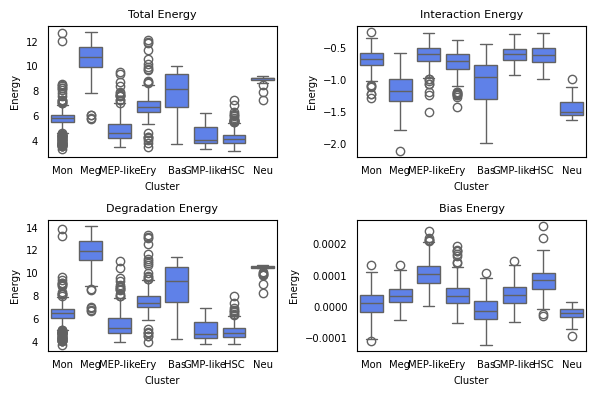

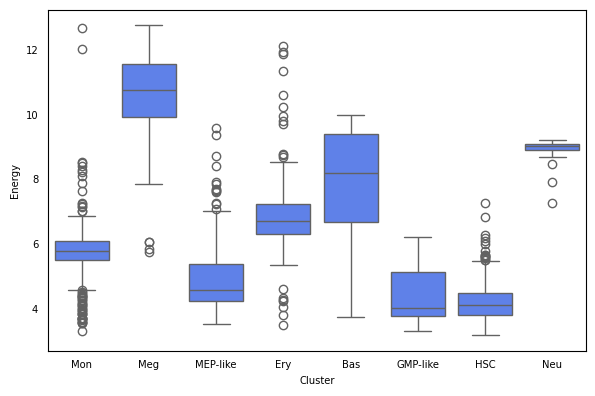

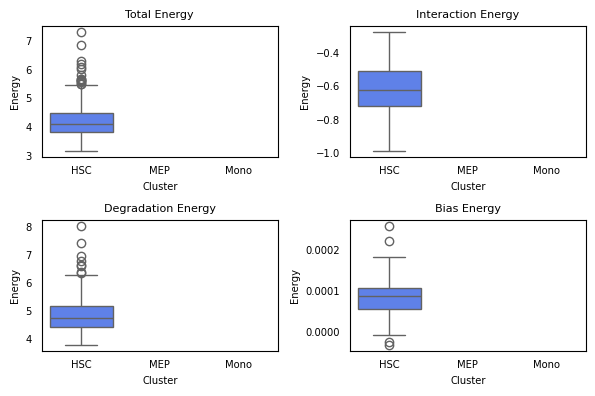

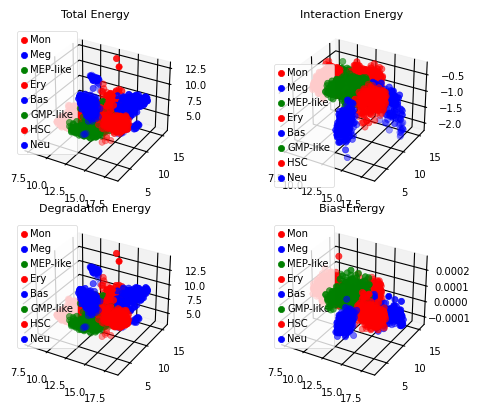

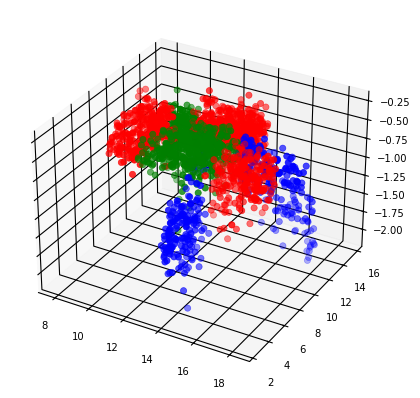

In [15]:
# Plot boxplots for all energy types
sch.pl.plot_energy_boxplots(adata, cluster_key='cell_type')

# Plot only total energy boxplot
sch.pl.plot_energy_boxplots(adata, cluster_key='cell_type', plot_energy='total')

# Plot with custom order and colors
sch.pl.plot_energy_boxplots(adata, cluster_key='cell_type',
                            order=['HSC', 'MEP', 'Mono'],
                            colors=['red', 'blue', 'green'])

# 3D scatter plots
sch.pl.plot_energy_scatters(adata, cluster_key='cell_type',
                            basis='umap', show_legend=True)

# Plot specific energy type
sch.pl.plot_energy_scatters(adata, cluster_key='cell_type',
                              plot_energy='interaction')

# Dendrograms

## Cell type dendrogram

In [16]:
# Compute celltype correlation using scHopfield
sch.tl.celltype_correlation(adata, spliced_key=SPLICED_KEY,cluster_key=CLUSTER_KEY)

<Figure size 900x300 with 0 Axes>

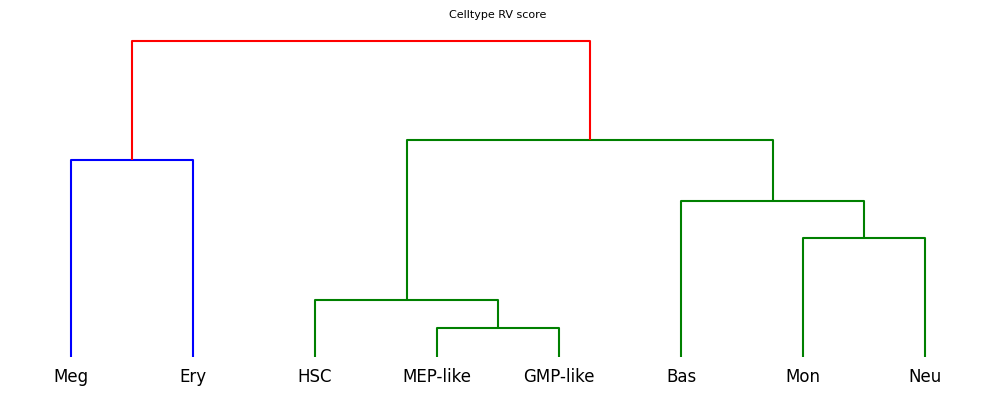

In [17]:
cells_correlation = adata.uns['scHopfield']['celltype_correlation']
plt.figure(figsize=(9, 3))
Z = scp.cluster.hierarchy.linkage(squareform(1-cells_correlation), 'complete')
fig,axs = plt.subplots(1,1,figsize=(10, 4), tight_layout=True)
scp.cluster.hierarchy.dendrogram(Z, labels = cells_correlation.index, ax=axs)
axs.get_yaxis().set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.set_title('Celltype RV score')
plt.show()

## Network dendrogram

In [18]:
# Compute network correlations using scHopfield
sch.tl.network_correlations(adata, cluster_key=CLUSTER_KEY)

/home/bernaljp/miniconda3/envs/SCH/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/bernaljp/miniconda3/envs/SCH/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [19]:
pearson = adata.uns['scHopfield']['network_correlations']['pearson']
hamming = adata.uns['scHopfield']['network_correlations']['hamming']
pearson_bin = adata.uns['scHopfield']['network_correlations']['pearson_bin']

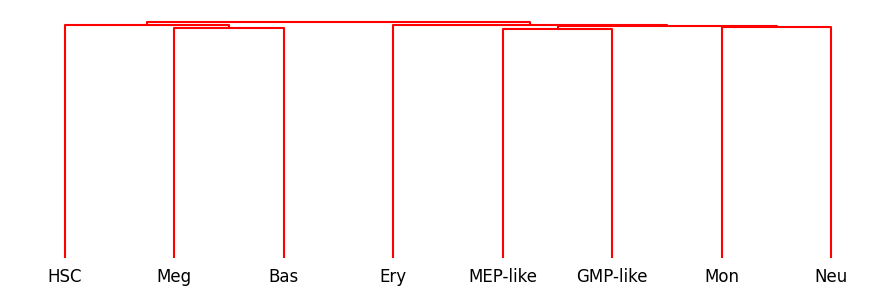

In [20]:
fig,axs = plt.subplots(1,1,figsize=(9, 3), tight_layout=True)
axs.get_yaxis().set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)

Z = scp.cluster.hierarchy.linkage(squareform(1-pearson), 'complete')
scp.cluster.hierarchy.dendrogram(Z, labels = pearson.index)
plt.show()

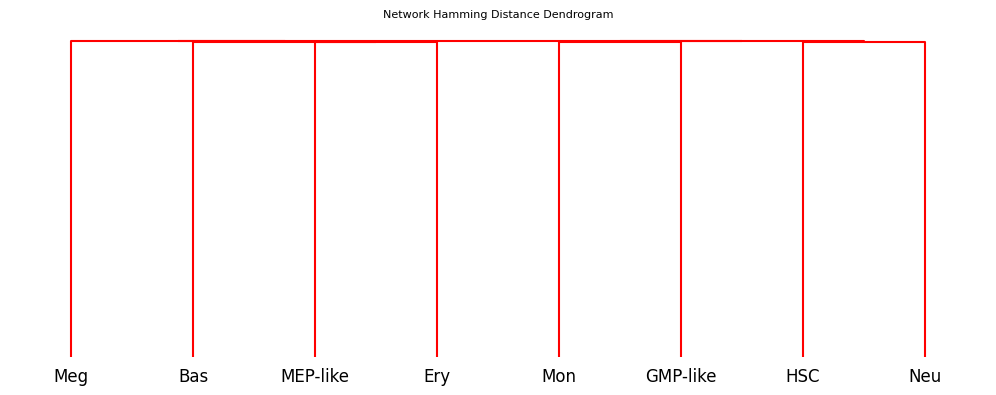

In [21]:
fig,axs = plt.subplots(1,1,figsize=(10, 4), tight_layout=True)
axs.get_yaxis().set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.set_title('Network Hamming Distance Dendrogram')

Z = scp.cluster.hierarchy.linkage(squareform(hamming), 'complete')
scp.cluster.hierarchy.dendrogram(Z, labels = hamming.index)
plt.show()

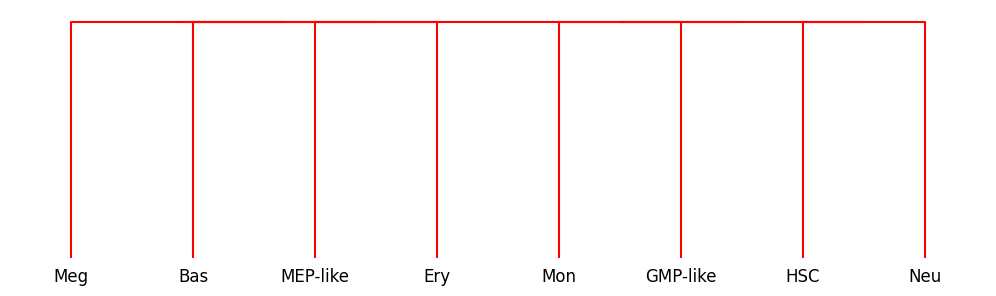

In [22]:
fig,axs = plt.subplots(1,1,figsize=(10, 3), tight_layout=True)
axs.get_yaxis().set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)

Z = scp.cluster.hierarchy.linkage(squareform(1-pearson_bin), 'complete')
scp.cluster.hierarchy.dendrogram(Z, labels = pearson_bin.index)
plt.show()

# Symmetricity

In [ ]:
def symmetricity(A, norm=2):
    S = np.linalg.norm((A+A.T)/2, ord=norm)
    As = np.linalg.norm((A-A.T)/2, ord=norm)
    return (S-As)/(S+As)

# Get interaction matrices from scHopfield storage
W = {}
genes_used = adata.var['use_for_dynamics'].values
gene_names = adata.var_names[genes_used]
for cluster in CELL_TYPE_ORDER:
    W[cluster] = adata.varp[f'W_{cluster}'][genes_used][:,genes_used]

syms = np.array([symmetricity(W[k], norm=2) for k in CELL_TYPE_ORDER])
idxs = np.argsort(syms)
plt.figure(figsize=(5,4), tight_layout=True)
plt.scatter(range(len(W)), syms, s=200, marker='*', c=[colors[i] for i in CELL_TYPE_ORDER])
plt.xticks(range(len(W)), np.array(CELL_TYPE_ORDER))
plt.ylabel('Symmetricity')
plt.xticks(rotation=-30)
plt.title('Distribution of Symmetricity across Weights')
plt.show()

# Model Analysis

In [ ]:
gamma = {}
I = {}
for cluster in CELL_TYPE_ORDER:
    gamma[cluster] = adata.var[f'gamma_{cluster}'].values[genes_used] if f'gamma_{cluster}' in adata.var.columns else adata.var[DEGRADATION_KEY].values[genes_used]
    I[cluster] = adata.var[f'I_{cluster}'].values[genes_used] if f'I_{cluster}' in adata.var.columns else np.zeros(genes_used.sum())

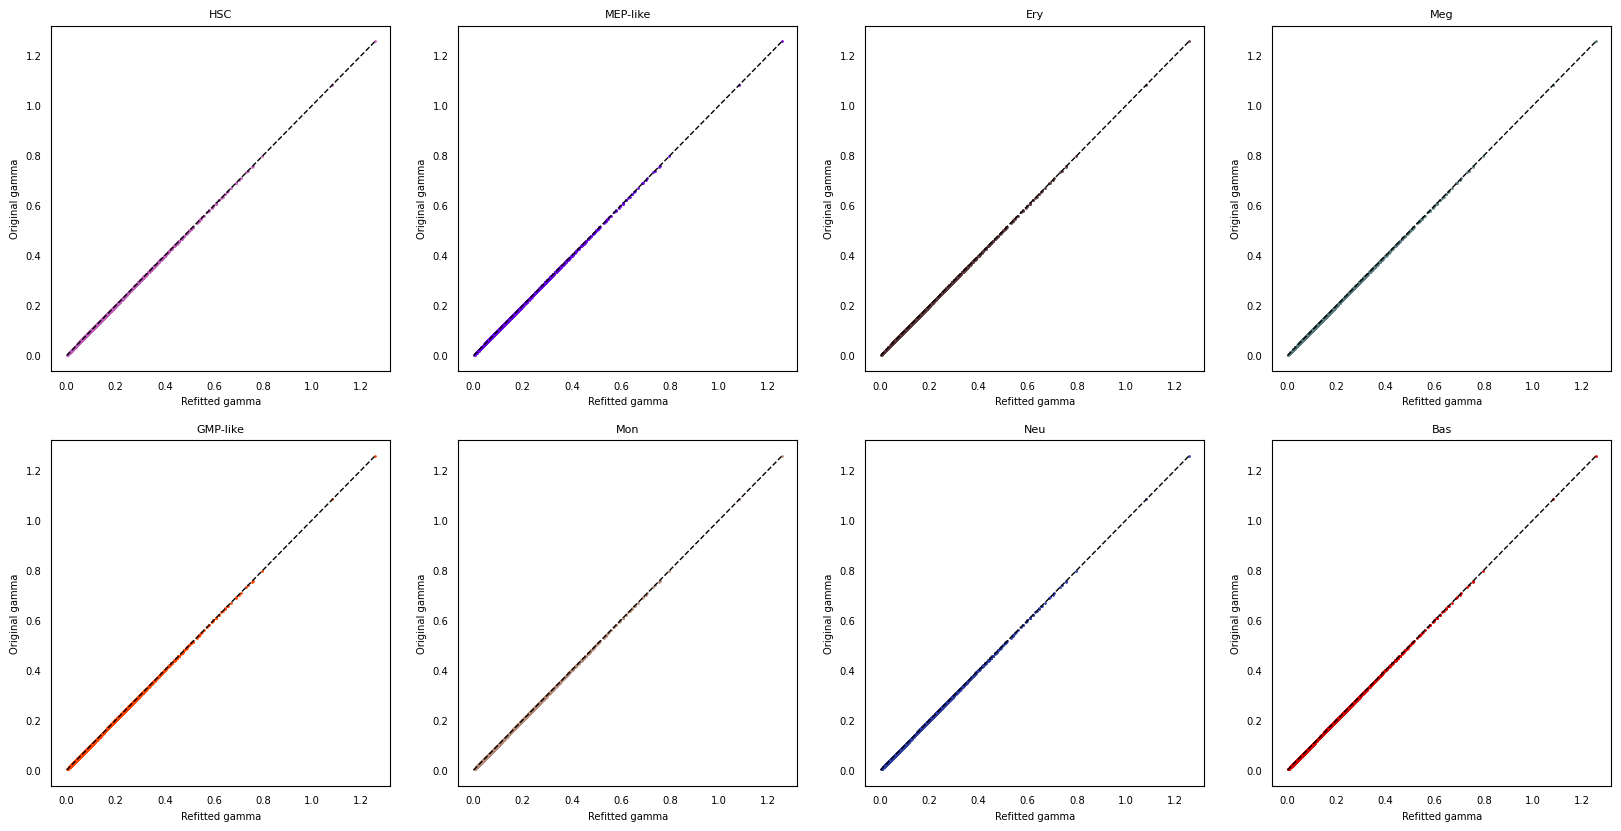

In [ ]:
fig,axs = plt.subplots(2,4,figsize=(20,10))
for cl,ax in zip(CELL_TYPE_ORDER,axs.flatten()):
    ax.scatter(gamma[cl], adata.var[DEGRADATION_KEY][genes_used], color=colors[cl], s=2)
    ax.set_title(cl)
    max_gamma = max(np.concatenate([gamma[cl], adata.var[DEGRADATION_KEY][genes_used]]))
    ax.set_xlabel('Refitted gamma')
    ax.set_ylabel('Original gamma')
    ax.plot([0, max_gamma], [0, max_gamma], color='k', ls='--', lw=1)
plt.show()

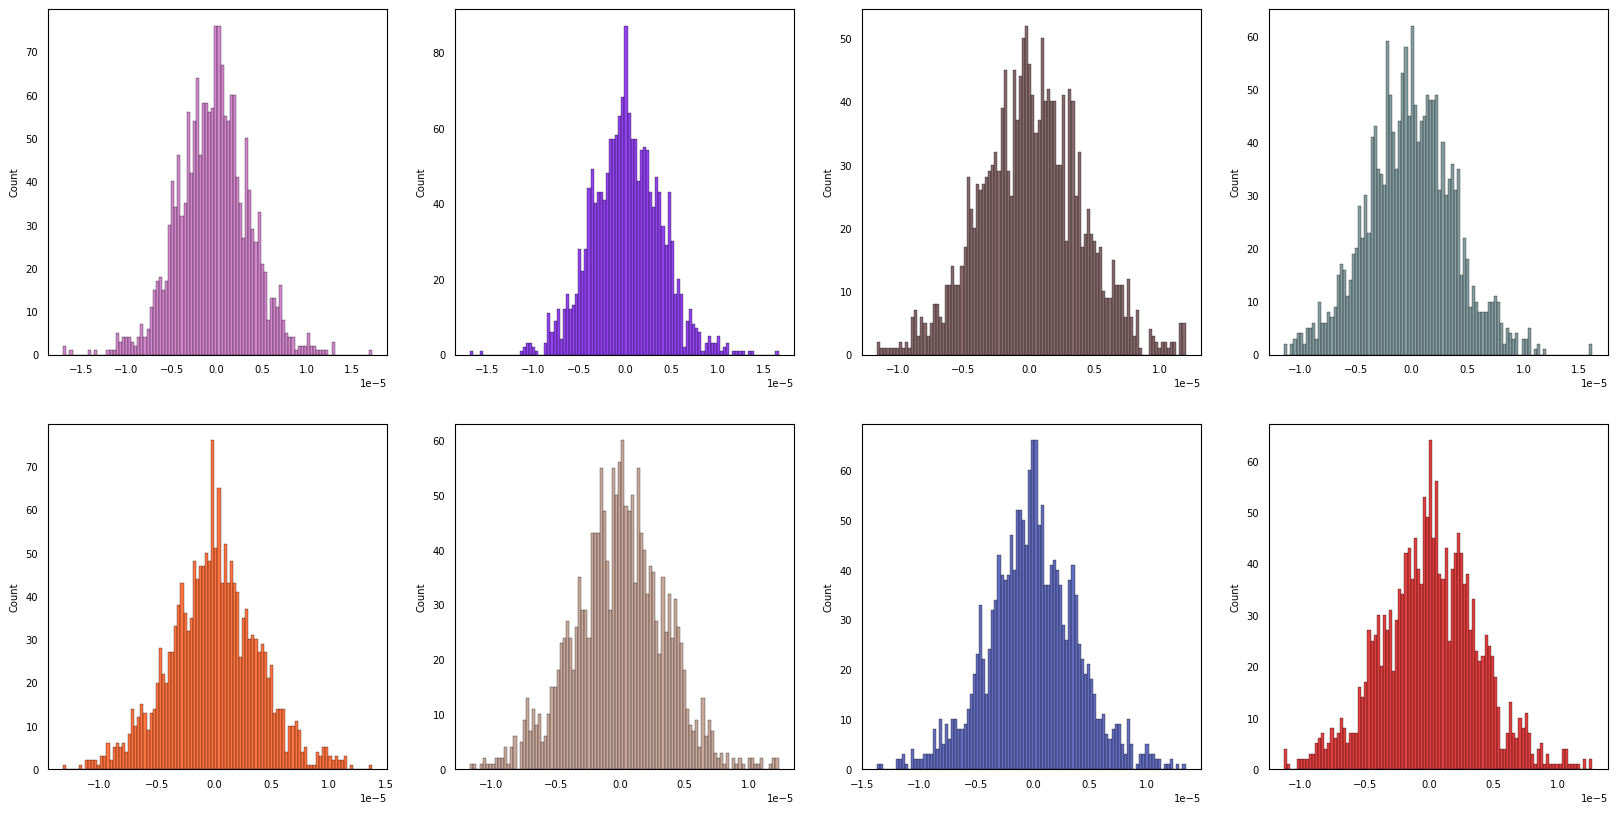

In [ ]:
fig,axs = plt.subplots(2,4,figsize=(20,10))
for cl,ax in zip(CELL_TYPE_ORDER,axs.flatten()):
   sns.histplot(I[cl].flatten(), bins=100,ax=ax, color=colors[cl])
plt.show()

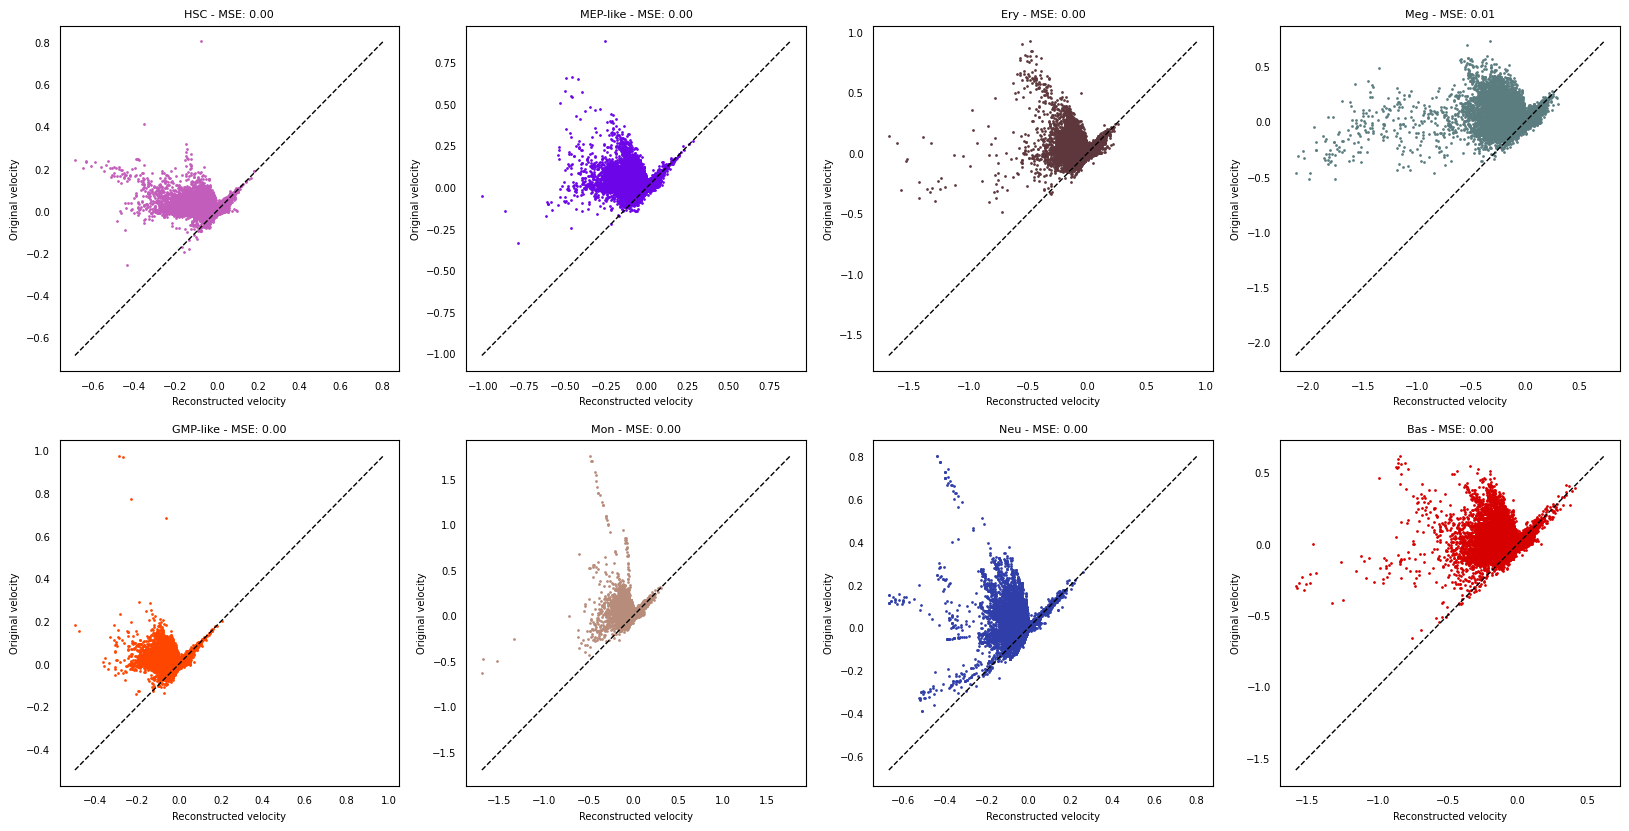

In [ ]:
# Get MSE for each cluster
mse_dict = sch.tl.validate_velocity(
    adata,
    velocity_key=VELOCITY_KEY,
    spliced_key=SPLICED_KEY,
    cluster_key=CLUSTER_KEY,
    return_mse=False  # Returns dict with per-cluster MSE
)

# Then plot
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for cl, ax in zip(CELL_TYPE_ORDER, axs.flatten()):
    reconstructed_v = sch.tl.compute_reconstructed_velocity(
        adata, cluster=cl, spliced_key=SPLICED_KEY, cluster_key=CLUSTER_KEY
    )

    genes_used = sch._utils.io.get_genes_used(adata)
    cluster_mask = (adata.obs[CLUSTER_KEY] == cl).values
    original_v = adata.layers[VELOCITY_KEY][cluster_mask][:, genes_used]

    ax.scatter(reconstructed_v.flatten(), original_v.toarray().flatten(), color=colors[cl], s=2)
    ax.set_title(f'{cl} - MSE: {mse_dict[cl]:.2f}')
    ax.set_xlabel('Reconstructed velocity')
    ax.set_ylabel('Original velocity')

    min_v = min(np.concatenate([reconstructed_v.flatten(), original_v.toarray().flatten()]))
    max_v = max(np.concatenate([reconstructed_v.flatten(), original_v.toarray().flatten()]))
    ax.plot([min_v, max_v], [min_v, max_v], c='k', ls='--', lw=1)

plt.show()

# Correlations

In [ ]:
# Compute energy-gene correlations using scHopfield
sch.tl.energy_gene_correlation(adata, spliced_key=SPLICED_KEY, cluster_key=CLUSTER_KEY)

/home/bernaljp/miniconda3/envs/SCH/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/bernaljp/miniconda3/envs/SCH/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/bernaljp/miniconda3/envs/SCH/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/bernaljp/miniconda3/envs/SCH/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/bernaljp/miniconda3/envs/SCH/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/bernaljp/miniconda3/envs/SCH/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered i

In [ ]:
df_correlations = sch.tl.get_correlation_table(
      adata,
      cluster_key=CLUSTER_KEY,
      energy_type='total',  # or 'interaction', 'degradation', 'bias'
      n_top_genes=100,
      order=CELL_TYPE_ORDER  # optional: specify cluster order
  )
df_correlations

HSC                MEP-like                 Ery                 Meg  \
        Gene Correlation        Gene Correlation    Gene Correlation    Gene   
0       CRYM    0.737177        RORA    0.829851  DIAPH1    0.853267   LTBP1   
1       RORA    0.706360    SLC30A10    0.820203  ITGA2B    0.833027    GPX1   
2   SLC30A10    0.701417  AC108519.1    0.813624  HEXIM1    0.832157     GSN   
3      TIAM1    0.695909       MBNL3    0.811126   PTGS1    0.826035   THBS1   
4      EXTL3    0.692921     PGAM1P5    0.810793   IL21R    0.821191  MPIG6B   
..       ...         ...         ...         ...     ...         ...     ...   
95   FAM174C    0.443646       IGF2R    0.554202   F13A1    0.671896  C2CD2L   
96  C15orf39    0.443476         EYS    0.553185   ITGB5    0.669834    FLI1   
97   PLEKHG3    0.442790     SMARCD2    0.549612  SAMD14    0.669214    MCL1   
98      APRT    0.441483     CDK2AP2    0.548768  SH3BP5    0.668828     CD9   
99      NOL6    0.441448        CTSD    0.548402     MN1    0.668631  NCKAP1   

               GMP-like                  Mon                    Neu  \
   Correlation     Gene Correlation     Gene Correlation       Gene   
0     0.937511     RORA    0.870617     GPX1    0.688572    S100A11   
1     0.922065  PGAM1P5    0.868383     PPIF    0.687483     IL17RA   
2     0.913736    MBNL3    0.866992  PGAM1P5    0.656172      FMNL3   
3     0.905252    EXTL3    0.865900     LMNA    0.645621      PPM1F   
4     0.904849    TIAM1    0.860524     PATJ    0.642485   HLA-DQB1   
..         ...      ...         ...      ...         ...        ...   
95    0.746745   PLCXD1    0.603640   HEXIM1    0.505695       SPTB   
96    0.743968   FERMT3    0.603218    ABCC3    0.504743     ZNF641   
97    0.742715      FBL    0.601991    RAB3C    0.500465       MBD5   
98    0.741958    PSMB3    0.601110    VPS18    0.499453       DGKH   
99    0.738912     BYSL    0.600801  ATP6AP1    0.494861  LINC01010   

                      Bas              
   Correlation       Gene Correlation  
0     0.912616        LIF    0.905139  
1     0.896081      CKAP4    0.899109  
2     0.895736       JUND    0.890071  
3     0.892220      AHNAK    0.880157  
4     0.890715       MYL6    0.877820  
..         ...        ...         ...  
95    0.814878  LINC00623    0.741319  
96    0.814669       CRYM    0.740037  
97    0.814522      IL2RG    0.738636  
98    0.813837    ALOX5AP    0.736432  
99    0.811092       PATJ    0.736314  

[100 rows x 16 columns]

In [ ]:
adata

AnnData object with n_obs × n_vars = 1947 × 1728
    obs: 'batch', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase', 'leiden', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'pca_ddhodge_div', 'pca_ddhodge_potential', 'acceleration_pca', 'curvature_pca', 'n_counts', 'mt_frac', 'jacobian_det_pca', 'manual_selection', 'divergence_pca', 'curv_leiden', 'curv_louvain', 'SPI1->GATA1_jacobian', 'jacobian', 'umap_ori_leiden', 'umap_ori_louvain', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'acceleration_umap', 'control_point_umap_ori', 'inlier_prob_umap_ori', 'obs_vf_angle_umap_ori', 'curvature_umap_ori', 'energy_total', 'energy_interaction', 'energy_degradation', 'ene

In [ ]:
# Get genes used in analysis
genes = sch._utils.io.get_genes_used(adata)
gene_names = adata.var.index[genes]

# Build correlation dictionary from adata.var columns
correlation = {}
for cluster in CELL_TYPE_ORDER:
    corr_col = f'correlation_total_{cluster}'
    if corr_col in adata.var.columns:
        correlation[cluster] = adata.var[corr_col].values[genes]
    else:
        print(f"Warning: No correlation data for {cluster}")

# Also check for 'all' if it exists
if 'correlation_total_all' in adata.var.columns:
    correlation['all'] = adata.var['correlation_total_all'].values[genes]

# Find corner genes
corner_genes = np.array([])
clus1_low = -0.4
clus1_high = 0.4
clus2_low = -0.4
clus2_high = 0.4
nn = 5

for corr1, corr2 in itertools.combinations(CELL_TYPE_ORDER, 2):
    if corr1 not in correlation or corr2 not in correlation:
        continue

    corr1_vals = correlation[corr1]
    corr2_vals = correlation[corr2]

    positions_corners = np.logical_or(
        np.logical_and(corr1_vals >= clus1_high, corr2_vals <= clus2_low),
        np.logical_and(corr1_vals <= clus1_low, corr2_vals >= clus2_high)
    )

    corr_corners = np.where(positions_corners)[0]
    corr_indices = np.argsort((corr1_vals[corr_corners])**2 + (corr2_vals[corr_corners])**2)[-nn:]
    corr_corners = corr_corners[corr_indices]
    corner_genes = np.concatenate((corner_genes, gene_names[corr_corners]))

corner_genes = np.unique(corner_genes)

# Create DataFrame from correlation dictionary
df_corr_corners = pd.DataFrame.from_dict(correlation)
df_corr_corners.drop('all', axis=1, inplace=True, errors='ignore')
df_corr_corners.index = gene_names
df_corr_corners = df_corr_corners.loc[corner_genes]

print(f"Found {len(corner_genes)} corner genes")

Found 56 corner genes


In [ ]:
ls.plot_correlations_grid(energy='total', order=order, colors=colors, x_low=-0.4, y_high=0.4, x_high=0.4, y_low=-0.4)
plt.show()

In [ ]:
ls.plot_correlations_grid(energy='interaction', order=order, colors=colors, x_low=-0.4, y_high=0.4, x_high=0.4, y_low=-0.4)
plt.show()

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(18,6),tight_layout=True)
if name.lower() in ['endocrinogenesis', 'endocrinogenesis_preprocessed']:
    ls.plot_gene_correlation_scatter('Ngn3 high EP', 'Pre-endocrine', energy='total', annotate=6, ax=ax[0])
    ls.plot_gene_correlation_scatter('Alpha', 'Delta', energy='total', annotate=6, ax=ax[1])
    ls.plot_gene_correlation_scatter('Ngn3 high EP', 'Pre-endocrine', energy='total', annotate=6, ax=ax[2])
else:
    ls.plot_gene_correlation_scatter('Meg', 'Ery', energy='total', annotate=6, ax=ax[0], clus1_low=-0.4, clus1_high=0.4, clus2_low=-0.4, clus2_high=0.4)
    ls.plot_gene_correlation_scatter('Neu', 'Bas', energy='total', annotate=6, ax=ax[1])
    ls.plot_gene_correlation_scatter('Neu', 'Mon', energy='total', annotate=6, ax=ax[2])
plt.show()


# Network scores

### Code

In [ ]:
def get_links_dict(ls):
    links = {}
    for k, w in ls.W.items():
        links[k] = pd.DataFrame(w.T, index=ls.gene_names, columns=ls.gene_names).reset_index()
        links[k] = links[k].melt(id_vars='index', value_vars=links[k].columns, var_name='target', value_name='coef_mean')
        links[k] = links[k][links[k]['coef_mean'] != 0]
        links[k].rename(columns={'index': 'source'}, inplace=True)
        links[k]['coef_abs'] = np.abs(links[k]['coef_mean'])
        links[k]['p'] = 0
        links[k]['-logp'] = np.nan
    return links

def plot_scores_as_rank(links, clusters=None, axs=None, n_gene=50, values=None, colors=None, skip_first_n=0, return_table=False):
    """
    Pick up top n-th genes wich high-network scores and make plots.

    Args:
        links (Links object): See network_analisis.Links class for detail.
        cluster (str): Cluster nome to analyze.
        n_gene (int): Number of genes to plot. Default is 50.
        save (str): Folder path to save plots. If the folde does not exist in the path, the function create the folder.
            If None plots will not be saved. Default is None.
    """
    values = links.merged_score.columns.drop('cluster') if values is None else values
    n_cols = len(values)
    clusters = links.cluster if clusters is None else np.array([clusters]).ravel().tolist()
    n_rows = len(clusters)
    size_per_gene = 0.2

    _, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*n_gene*size_per_gene), tight_layout=True) if axs is None else (None,axs)

    df_table = pd.DataFrame(index=range(n_gene), columns=pd.MultiIndex.from_product([clusters, values, ['Gene','Value']], names=['cluster', 'score', 'values']))
    
    for i, (axs_row, cluster) in enumerate(zip(axs, clusters)):
        color = colors[cluster] if colors is not None else 'tab:blue'
        for j, (ax, value) in enumerate(zip(axs_row, values)):
            res = links.merged_score[links.merged_score.cluster == cluster]
            res = res[value].sort_values(ascending=False)
            res = res[skip_first_n:n_gene+skip_first_n]

            ax.scatter(res.values, range(len(res)), color=color)
            ax.set_yticks(range(len(res)), res.index.values)
            if i == 0:
                if skip_first_n == 0:
                    ax.set_title(f" {value.replace('_',' ').capitalize()} \n top {n_gene}")
                else:
                    ax.set_title(f" {value.replace('_',' ').capitalize()} \n top {n_gene} (skip {skip_first_n})")
            if j == 0:
                ax.set_ylabel(cluster)            
            ax.invert_yaxis()

            if return_table:
                df_table[(cluster, value, 'Gene')] = res.index.values
                df_table[(cluster, value, 'Value')] = res.values
    if return_table:
        return df_table

In [ ]:
def _plot_goi(x, y, goi, args_annot, scatter=False, x_shift=0.1, y_shift=0.1, ax=None):
    """
    Plot an annoation to highlight one point in scatter plot.

    Args:
        x (float): Cordinate-x.
        y (float): Cordinate-y.
        args_annot (dictionary): arguments for matplotlib.pyplot.annotate().
        scatter (bool): Whether to plot dot for the point of interest.
        x_shift (float): distance between the annotation and the point of interest in the x-axis.
        y_shift (float): distance between the annotation and the point of interest in the y-axis.
    """

    default = {"size": 10}
    default.update(args_annot)
    args_annot = default.copy()

    arrow_dict = {"width": 0.5, "headwidth": 0.5, "headlength": 1, "color": "black"}
    plotter = plt if ax is None else ax
    if scatter:
        plotter.scatter(x, y, c="none", edgecolor="black")
    plotter.annotate(f"{goi}", xy=(x, y), xytext=(x+x_shift, y+y_shift),
                 color="black", arrowprops=arrow_dict, **args_annot)
    
def plot_score_comparison_2D(links, value, cluster1, cluster2, percentile=99, annot_shifts=None, save=None, fillna_with_zero=True, ignore_genes=[], plt_show=True, ax=None):
    """
    Make a scatter plot that shows the relationship of a specific network score in two groups.

    Args:
        links (Links object): See network_analisis.Links class for detail.
        value (srt): The network score to be shown.
        cluster1 (str): Cluster nome to analyze. Network scores in the cluste1 are shown as x-axis.
        cluster2 (str): Cluster nome to analyze. Network scores in the cluste2 are shown as y-axis.
        percentile (float): Genes with a network score above the percentile will be shown with annotation. Default is 99.
        annot_shifts ((float, float)): Shift x and y cordinate for annotations.
        save (str): Folder path to save plots. If the folde does not exist in the path, the function create the folder.
            If None plots will not be saved. Default is None.
    """
    res = links.merged_score[links.merged_score.cluster.isin([cluster1, cluster2])][[value, "cluster"]]
    res = res.reset_index(drop=False)
    piv = pd.pivot_table(res, values=value, columns="cluster", index="index")
    piv.drop(ignore_genes, inplace=True, errors='ignore')
    if fillna_with_zero:
        piv = piv.fillna(0)
    else:
        piv = piv.fillna(piv.mean(axis=0))

    goi1 = piv[piv[cluster1] > np.percentile(piv[cluster1].values, percentile)].index
    goi2 = piv[piv[cluster2] > np.percentile(piv[cluster2].values, percentile)].index

    gois = np.union1d(goi1, goi2)
    not_gois = np.setdiff1d(piv.index, gois)
    piv_gois = piv.loc[gois]
    piv_not_gois = piv.loc[not_gois]

    x, y = piv_not_gois[cluster1], piv_not_gois[cluster2]
    plotter = plt if ax is None else ax
    plotter.scatter(x, y, c='lightgray', s=2)
    x, y = piv_gois[cluster1], piv_gois[cluster2]
    plotter.scatter(x, y, c="none", edgecolors='b')

    if annot_shifts is None:
        x_shift, y_shift = (x.max() - x.min())*0.03, (y.max() - y.min())*0.03
    else:
        x_shift, y_shift = annot_shifts
    for goi in gois:
        x, y = piv.loc[goi, cluster1], piv.loc[goi, cluster2]
        _plot_goi(x, y, goi, {}, scatter=False, x_shift=x_shift, y_shift=y_shift, ax=ax)

    if ax is None:
        plt.xlabel(cluster1)
        plt.ylabel(cluster2)
        # plt.title(f"{value}")
    else:
        ax.set_xlabel(cluster1)
        ax.set_ylabel(cluster2)


    if not save is None:
        os.makedirs(save, exist_ok=True)
        path = os.path.join(save, f"values_comparison_in_{links.name}_{value}_{links.threshold_number}_{cluster1}_vs_{cluster2}.{settings['save_figure_as']}")
        plt.savefig(path, transparent=True)
    if plt_show:
        plt.show()
def plot_score_per_cluster(links, goi, save=None, plt_show=True, ax=None):
    """
    Plot network score for a specific gene.
    This function can be used to compare network score of a specific gene between clusters
    and get insight about the dynamics of the gene.

    Args:
        links (Links object): See network_analisis.Links class for detail.
        goi (srt): Gene name.
        save (str): Folder path to save plots. If the folde does not exist in the path, the function create the folder.
            If None plots will not be saved. Default is None.
    """
    print(goi)
    res = links.merged_score[links.merged_score.index==goi]
    res = res.rename(
        columns={"degree_centrality_all": "degree\ncentrality",
                 "betweenness_centrality": "betweenness\ncentrality",
                 "eigenvector_centrality": "eigenvector\ncentrality"})
    # make plots
    values = [ "degree\ncentrality",  "betweenness\ncentrality",
              "eigenvector\ncentrality"]
    for i, value in zip([1, 2, 3], values):
        plt.subplot(1, 3,  i)
        ax = sns.stripplot(data=res, y="cluster", x=value,
                      size=10, orient="h",linewidth=1, edgecolor="w",
                      order=links.palette.index.values,
                      palette=dict(links.palette.palette))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.yaxis.grid(True)
        ax.tick_params(bottom=False,
                        left=False,
                        right=False,
                        top=False)
        if i > 1:
            plt.ylabel(None)
            ax.tick_params(labelleft=False)

    if not save is None:
        os.makedirs(save, exist_ok=True)
        path = os.path.join(save,
                           f"score_dynamics_in_{links.name}_{links.threshold_number}_{goi}.{settings['save_figure_as']}")
        plt.savefig(path, transparent=True)
    if plt_show:
        plt.show()

In [ ]:
def plot_score_comparison_grid(links, score="eigenvector_centrality", colors=None, order=None, ignore_genes=[], annotate_percentile=99, **kwargs):
    """
    Plots a matrix where the diagonal shows cell types and the off-diagonal
    plots show gene correlation scatter plots between cell types.

    Args:
        cell_types (list): List of cell types to plot.
        colors (dict): Dictionary mapping cell types to colors.
        name (str): Name of the plot or dataset for title adjustments.
    """
    cell_types = links.cluster if order is None else order
    n = len(cell_types)
    figsize = kwargs.pop('figsize', (15, 15))
    fontsize = kwargs.pop('fontsize', 30)
    tight_layout = kwargs.get('tight_layout', True)
    colors = colors if colors is not None else links.palette.to_dict()['palette']
    fig, axs = plt.subplots(n, n, figsize=figsize, tight_layout=tight_layout)
    fig.suptitle(score.replace('_', ' ').capitalize(), fontsize=fontsize)
    for i in range(n):
        for j in range(i, n):
            if i == j:
                text = cell_types[i]
                for spine in axs[i, j].spines.values():
                    spine.set_visible(True)
                    spine.set_linewidth(2)
                    spine.set_color(colors[text])
                # Remove ticks
                axs[i, j].set_xticks([])
                axs[i, j].set_yticks([])
                # Add text in the middle
                axs[i, j].set_facecolor(colors[text])
                text = text.replace(' ', '\n', 1)
                text = text.replace('-', '-\n')
                axs[i, j].text(0.5, 0.5, text, ha='center', va='center', fontsize=18, fontweight='bold', fontname='serif', transform=axs[i, j].transAxes)
                
                
                continue
            
            axs[i, j].axis('off')
            plot_score_comparison_2D(links, value=score,
                               cluster1=cell_types[i], cluster2=cell_types[j], 
                               percentile=annotate_percentile, ax=axs[j, i], plt_show=False, ignore_genes=ignore_genes, **kwargs)
           # Remove ticks
           
            axs[j, i].set_xlabel('')
            axs[j, i].set_ylabel('')
            # Adjust ticks for the first column and last row
            if i != 0: 
                axs[j, i].set_yticks([])
            if j != n - 1:
                axs[j, i].set_xticks([])

In [ ]:
def plot_score_per_cluster(links, goi, order=None, plt_show=True):
    """
    Plot network score for a specific gene.
    This function can be used to compare network score of a specific gene between clusters
    and get insight about the dynamics of the gene.

    Args:
        links (Links object): See network_analisis.Links class for detail.
        goi (srt): Gene name.
        save (str): Folder path to save plots. If the folde does not exist in the path, the function create the folder.
            If None plots will not be saved. Default is None.
    """
    print(goi)
    res = links.merged_score[links.merged_score.index==goi]
    res = res.rename(
        columns={"degree_centrality_all": "degree\ncentrality",
                 "betweenness_centrality": "betweenness\ncentrality",
                 "eigenvector_centrality": "eigenvector\ncentrality"})
    # make plots
    values = [ "degree\ncentrality",  "betweenness\ncentrality",
              "eigenvector\ncentrality"]
    order = links.palette.index.values if order is None else order
    for i, value in zip([1, 2, 3], values):
        plt.subplot(1, 3,  i)
        ax = sns.stripplot(data=res, y="cluster", x=value,
                      size=10, orient="h",linewidth=1, edgecolor="w",
                      order=order,
                      palette=dict(links.palette.palette))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.yaxis.grid(True)
        ax.tick_params(bottom=False,
                        left=False,
                        right=False,
                        top=False)
        if i > 1:
            plt.ylabel(None)
            ax.tick_params(labelleft=False)

    if plt_show:
        plt.show()

In [ ]:
links_dict = get_links_dict(ls)
try:
    links_dict.__delitem__('all')
except:
    pass

links = co.network_analysis.links_object.Links(name=ls.cluster_key, links_dict=links_dict)

co.trajectory.oracle_utility._check_color_information_and_create_if_not_found(adata, ls.cluster_key, 'umap')
ls.adata.uns[f'{ls.cluster_key}_colors']
pd.DataFrame.from_dict(ls.adata.uns[f'{ls.cluster_key}_colors'], orient='index', columns=['palette'])
# pd.DataFrame(ls.adata.uns[f'{ls.cluster_key}_colors'], index=ls.adata.obs[ls.cluster_key].unique(), columns=['palette'])

try:
    links.palette = pd.DataFrame.from_dict(ls.adata.uns[f'{cluster_key}_colors'], orient='index', columns=['palette'])
except:
    links.palette = pd.DataFrame(ls.adata.uns[f'{cluster_key}_colors'], index=ls.adata.obs[ls.cluster_key].unique(), columns=['palette'])

links.filter_links(p=0.001, weight="coef_abs", threshold_number=40000)

# Calculate network scores. 
links.get_network_score()

In [ ]:
len(links.links_dict['HSC'].source.unique()),len(links.links_dict['HSC'].target.unique())

In [ ]:
values = [
          'degree_centrality_out',
          'betweenness_centrality',  
          'eigenvector_centrality',
          ]
df_scores = plot_scores_as_rank(links, clusters=order, values=values, colors=colors, n_gene=20, skip_first_n=0, return_table=True)
plt.show()

In [ ]:
# Group by cluster and get top 10 genes per cluster
top_genes_per_cluster = (
    links.merged_score[['betweenness_centrality','cluster']].groupby("cluster", group_keys=False)
    .apply(lambda x: x.nlargest(20, "betweenness_centrality")).reset_index(drop=False)
)
formatted_result = pd.DataFrame(index=range(20),columns=pd.MultiIndex.from_product([order, ['Gene', 'Betweenness']]))
for cluster in order:
    formatted_result[cluster] = top_genes_per_cluster[top_genes_per_cluster.cluster == cluster][['index', 'betweenness_centrality']].values
formatted_result


In [ ]:
# Group by cluster and get top 10 genes per cluster
top_genes_per_cluster = (
    links.merged_score[['degree_centrality_out','cluster']].groupby("cluster", group_keys=False)
    .apply(lambda x: x.nlargest(20, "degree_centrality_out")).reset_index(drop=False)
)
formatted_result = pd.DataFrame(index=range(20),columns=pd.MultiIndex.from_product([order, ['Gene', 'Degree Centrality']]))
for cluster in order:
    formatted_result[cluster] = top_genes_per_cluster[top_genes_per_cluster.cluster == cluster][['index', 'degree_centrality_out']].values
formatted_result


In [ ]:
formatted_result[[(cl,'Gene') for cl in order]]

In [ ]:
links.merged_score[['betweenness_centrality','cluster']].loc[np.unique(formatted_result.iloc[:,::2].values)].reset_index(drop=False).pivot_table(index='index', columns='cluster', values='betweenness_centrality')

In [ ]:
plot_score_comparison_grid(links, score="betweenness_centrality", figsize=(20, 20), ignore_genes=[], annotate_percentile=99.6, order=order)
plt.show()

In [ ]:
if name.lower() in ['endocrinogenesis', 'endocrinogenesis_preprocessed']:
    list_of_genes = ['Malat1', 'Ins2', 'Ptprn2', 'Ghr', 'Ccnd2','Dach1', 'Actb', 'Etv1', 'Pdx1', 'Isl1', 'Hhex']
elif name.lower() in ['hematopoiesis']:
    # list_of_genes = ["GATA2", "PLEK", "RUNX1", "GATA1", "CEBPA", "SPI1"]
    list_of_genes = ['ID2', 'HOXA10', 'RORA', 'TAL1', 'CUX1', 'GATA2', 'STAT2', 'SPI1', 'FOXP1']

for gg in list_of_genes:
    plt.figure(figsize=(6,6))
    plot_score_per_cluster(links, gg, order=order, plt_show=True)

### Betweenness vs Degree

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

goi_high_betweenness_low_degree = pd.Index([])
top_n_genes_per_cluster = {}
for cl, ax in zip(order, axs.flat):
    df_tmp = links.merged_score[links.merged_score.cluster == cl]
    
    # Filter genes with degree lower than 0.5
    filtered_df = df_tmp[df_tmp['degree_centrality_all'] < 0.5]
    
    # Select top 3 genes with highest betweenness centrality
    top_genes = filtered_df.nlargest(3, 'betweenness_centrality')
    goi_high_betweenness_low_degree = goi_high_betweenness_low_degree.union(top_genes.index)
    top_n_genes_per_cluster[cl] = top_genes['betweenness_centrality'].to_dict()
    
    # Plot scatter
    df_tmp.plot(kind='scatter', x='betweenness_centrality', y='degree_centrality_all', 
                ax=ax, color=colors[cl], s=10)
    
    # Annotate top genes
    for gene, row in top_genes.iterrows():
        ax.annotate(gene, (row['betweenness_centrality'], row['degree_centrality_all']),
                    fontsize=10, ha='right', va='bottom', color='black')

    ax.set_title(cl)
    ax.set_xlabel('Betweenness')
    ax.set_ylabel('Degree')

plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

goi_high_betweenness_low_degree = pd.Index([])
top_n_genes_per_cluster = {}
for cl, ax in zip(order, axs.flat):
    df_tmp = links.merged_score[links.merged_score.cluster == cl]
    
    # Filter genes with degree lower than 0.5
    filtered_df = df_tmp[df_tmp['betweenness_centrality'] < 1000]
    
    # Select top 3 genes with highest betweenness centrality
    top_genes = filtered_df.nlargest(3, 'degree_centrality_all')
    goi_high_betweenness_low_degree = goi_high_betweenness_low_degree.union(top_genes.index)
    top_n_genes_per_cluster[cl] = top_genes['degree_centrality_all'].to_dict()
    
    # Plot scatter
    df_tmp.plot(kind='scatter', x='betweenness_centrality', y='degree_centrality_all', 
                ax=ax, color=colors[cl], s=10)
    
    # Annotate top genes
    for gene, row in top_genes.iterrows():
        ax.annotate(gene, (row['betweenness_centrality'], row['degree_centrality_all']),
                    fontsize=10, ha='right', va='bottom', color='black')

    ax.set_title(cl)
    ax.set_xlabel('Betweenness')
    ax.set_ylabel('Degree')

plt.tight_layout()
plt.show()

In [ ]:
goi_high_betweenness_low_degree

Index(['AHRR', 'CUX1', 'E2F4', 'ERG', 'HIVEP1', 'HOXA10', 'ID2', 'KLF16',
       'MBD2', 'MEF2D', 'MEIS1', 'MLX', 'MYCN', 'MYPOP', 'NRF1', 'RUNX1',
       'STAT2', 'TCF3'],
      dtype='object')

In [ ]:
links.merged_score[['betweenness_centrality', 'degree_centrality_all', 'cluster']].loc[goi_high_betweenness_low_degree].reset_index(drop=False).pivot_table(index='index', columns='cluster', values=['betweenness_centrality','degree_centrality_all'], aggfunc='first')#.sort_index(axis=1, ascending=True)

### Degree centrality all

In [ ]:
df = links.merged_score[['degree_centrality_all','cluster']].reset_index(drop=False).pivot_table(index='index', columns='cluster', values='degree_centrality_all')
df_degree_sorted = pd.DataFrame(index=range(10), columns=pd.MultiIndex.from_product([order, ['Gene', 'Degree Centrality All']]))
for cl in order:
    indices_for_table = df[cl].sort_values(ascending=False).index[:10]
    df_degree_sorted[cl] = df.loc[indices_for_table, cl].reset_index().values
df_degree_sorted

### Eigenvector centrality

In [ ]:
df = links.merged_score[['eigenvector_centrality', 'cluster']].reset_index(drop=False).pivot_table(index='index', columns='cluster', values='eigenvector_centrality')
df_ev_centrality_sorted = pd.DataFrame(index=range(10), columns=pd.MultiIndex.from_product([order, ['Gene', 'Eigenvector Centrality']]))
for cl in order:
    indices_for_table = df[cl].sort_values(ascending=False).index[:10]
    df_ev_centrality_sorted[cl] = df.loc[indices_for_table, cl].reset_index().values
df_ev_centrality_sorted

# Eigenvalues

## Code

In [ ]:
e_vals = {}
e_vecs = {}
v_svd = {}
s2_svd = {}
ut_svd = {}

for i, cell_type in tqdm(enumerate(order)):
    e_vals[cell_type], e_vecs[cell_type] = np.linalg.eig(ls.W[cell_type])
    v_svd[cell_type], s2_svd[cell_type], ut_svd[cell_type] = np.linalg.svd(ls.W[cell_type])

## Check for the outlier eigenvalues and the corresponding eigenvectors, what genes are the predominant in the eigenvectors?
## Check also the genes with the highest negative real part of the eigenvalues
# Genes with the highest degradation energy per gene


8it [00:05,  1.47it/s]


In [ ]:
# Define constants and parameters
n_genes = 20
part = 'real'  # Can be 'real', 'imag', or 'abs'
exclude_genes = []
genes_in = np.where(~np.isin(ls.gene_names, exclude_genes))[0]

# Get the eigenvectors sorted by eigenvalues
df_rankings = pd.DataFrame(index=range(len(ls.gene_names)))

fig = plt.figure(figsize=(15, 64), tight_layout=True)
gs = fig.add_gridspec(16,4)
gene_axs = [[gs[i,j] for j in range(4)] for i in range(0,16,2)]
total_axs = [[gs[i,j:j+2] for j in range(0,4,2)] for i in range(1,16,2)]


for k,gene_ax,total_ax in zip(order,gene_axs,total_axs):
    eigenvalues = e_vals[k]
    eigenvectors = e_vecs[k][:, np.argsort(eigenvalues.real)[::-1]]
    for eig_n,ax in enumerate(gene_ax):
# Choose the part to plot (real, imaginary, or absolute value)
        parts = {
            'real': eigenvectors[:, eig_n].real,
            'imag': eigenvectors[:, eig_n].imag,
            'abs': np.abs(eigenvectors[:, eig_n])
        }
        vector_to_plot = parts[part][genes_in]

    # Create the plot
        sorted_indices = np.argsort(vector_to_plot)
        sorted_indices_absolute = np.argsort(np.abs(vector_to_plot))[::-1]
        indices_to_plot = sorted_indices_absolute[:n_genes]

        x_data = [np.where(sorted_indices==idx)[0][0] for idx in indices_to_plot]
        y_data = vector_to_plot[indices_to_plot]
        names = ls.gene_names[indices_to_plot]

        df_rankings[f'{k} {part} eigenvector {eig_n+1} genes'] = ls.gene_names[sorted_indices]
        df_rankings[f'{k} {part} eigenvector {eig_n+1}'] = vector_to_plot[sorted_indices]

                        
    for par,ax in zip(['real','imag'],total_ax):
        evecs = e_vecs[k].real if par=='real' else e_vecs[k].imag
        evals = e_vals[k].real if par=='real' else e_vals[k].imag

        e_score = evecs @ evals

        sorted_indices = np.argsort(e_score)
        sorted_indices_absolute = np.argsort(np.abs(e_score))[::-1]
        indices_to_plot = sorted_indices_absolute[:n_genes]

        df_rankings[f'{k} {par} score genes'] = ls.gene_names[sorted_indices]
        df_rankings[f'{k} {par} score'] = e_score[sorted_indices]

        x_data = [np.where(sorted_indices==idx)[0][0] for idx in indices_to_plot]
        y_data = e_score[indices_to_plot]
        names = ls.gene_names[indices_to_plot]


In [ ]:
def linspace_iterator(start, stop, num):
    if num == 1:
        yield start
        return
    step = (stop - start) / float(num - 1)
    for i in range(num):
        yield start + i * step

def annotate_points(ax, x_data, y_data, labels, offset_x_fraction=0.1, offset_y_fraction=0.1):
    n_positive = sum(y >= 0 for y in y_data)
    n_negative = sum(y < 0 for y in y_data)
    n_total = len(y_data) // 2
    frac_positive = n_positive / n_total
    frac_negative = n_negative / n_total
    offsets_positive = linspace_iterator(-0.25 * offset_y_fraction * frac_positive, 1.75 * offset_y_fraction * frac_positive, n_positive)
    offsets_negative = linspace_iterator(-0.25 * offset_y_fraction * frac_negative, 1.75 * offset_y_fraction * frac_negative, n_negative)
    offset_x = offset_x_fraction

    for name, x, y in zip(labels, x_data, y_data):
        offset_y = next(offsets_positive) if y >= 0 else next(offsets_negative)

        # Convert offset to display coordinates
        offset_x_data = offset_x * ax.figure.dpi
        offset_y_data = offset_y * ax.figure.dpi

        # Determine text position based on y-value
        if y < 0:
            xytext = (offset_x_data, offset_y_data)
            ha = 'left'
        else:
            xytext = (-offset_x_data, -offset_y_data)
            ha = 'right'

        # Annotate the point
        ax.annotate(name, xy=(x, y), xytext=xytext, fontsize=8, ha=ha, textcoords='offset points', 
                    arrowprops=dict(arrowstyle="->", color='gray', lw=0.5))

# Define constants and parameters
n_genes = 10
n_genes_table = 100
part = 'real'  # Can be 'real', 'imag', or 'abs'
exclude_genes = []
genes_in = np.where(~np.isin(ls.gene_names, exclude_genes))[0]


## Figure

In [ ]:
fig, axs = plt.subplots(len(order), 3, figsize=(15, 3 * len(order)))
df_eigenvalues = pd.DataFrame(index=range(1,n_genes_table+1),columns=pd.MultiIndex.from_product([order, ['EV gene', 'EV value', 'Score gene', 'Score value']]))
top_evalues = {}

n_gernes = 10

for i, cell_type in enumerate(order):
    # Calculate eigenvalues and eigenvectors
    e_vals, e_vecs = np.linalg.eig(ls.W[cell_type])
    
    # Plot eigenvalues (real vs imaginary)
    ax = axs[i, 0]
    ax.scatter(e_vals.real, e_vals.imag, label=cell_type, color=colors[cell_type])
    ax.set_xlabel('Real part')
    ax.set_ylabel('Imaginary part')
    ax.legend()
    if i == 0:
        ax.set_title(f'Eigenvalues')

    # Plot sorted eigenvector components
    eigenvector = e_vecs[:, np.argmax(e_vals.real)]
    top_evalues[cell_type] = e_vals[np.argmax(e_vals.real)]
    sorted_indices_abs = np.argsort(np.abs(eigenvector))[::-1]
    sorted_indices = np.argsort(eigenvector)
    indices_for_table = sorted_indices_abs[:n_genes_table]
    indices_to_plot = sorted_indices_abs[:n_genes]
    
    x_data = [np.where(sorted_indices==idx)[0][0] for idx in indices_to_plot]
    y_data = eigenvector[indices_to_plot]
    names = ls.gene_names[indices_to_plot]

    df_eigenvalues[cell_type, 'EV gene'] = ls.gene_names[indices_for_table]
    df_eigenvalues[cell_type, 'EV value'] = list(map(lambda x: f'{np.real(x):.3f}', eigenvector[indices_for_table]))
    
    ax = axs[i, 1]
    ax.plot(eigenvector[sorted_indices], '.', color=colors[cell_type])
    ax.set_ylabel('Component value')
    annotate_points(ax, x_data, y_data, names, offset_x_fraction=0.2, offset_y_fraction=0.1)
    ax.set_xticks([])
    if i == 0:
        ax.set_title(f'First Eigenvector components')

    # Plot real eigenvector score sorted
    evecs = e_vecs.real if part=='real' else e_vecs.imag
    evals = e_vals.real if part=='real' else e_vals.imag

    e_score = evecs @ evals

    sorted_indices = np.argsort(e_score)
    sorted_indices_absolute = np.argsort(np.abs(e_score))[::-1]
    indices_to_plot = sorted_indices_absolute[:n_genes]
    indices_for_table = sorted_indices_abs[:n_genes_table]

    df_rankings[f'{cell_type} {part} score genes'] = ls.gene_names[sorted_indices]
    df_rankings[f'{cell_type} {part} score'] = e_score[sorted_indices]

    x_data = [np.where(sorted_indices==idx)[0][0] for idx in indices_to_plot]
    y_data = e_score[indices_to_plot]
    names = ls.gene_names[indices_to_plot]

    df_eigenvalues[cell_type, 'Score gene'] = ls.gene_names[indices_for_table]
    df_eigenvalues[cell_type, 'Score value'] = list(map(lambda x: f'{np.real(x):.3f}', e_score[indices_for_table]))

    ax = axs[i, 2]
    ax.plot(np.sort(e_score),'.',color=colors[cell_type])
    ax.set_ylabel('Component score')
    ax.set_xticks([])
    annotate_points(ax, x_data, y_data, names, offset_x_fraction=0.2, offset_y_fraction=0.1)
    if i == 0:
        ax.set_title(f'Eigenvector score')


# fig.savefig('../../FiguresForPaper/Eigenvectors.pdf')
plt.tight_layout()
plt.show()


In [ ]:
df = df_eigenvalues.loc[:, pd.MultiIndex.from_product([order, ['EV gene', 'EV value']])]

# Initialize an empty DataFrame to store sorted values
sorted_df = pd.DataFrame(index=df.index, columns=df.columns)

# Loop through each cluster (every 2 columns: "EV gene" and "EV value")
for cluster in df.columns.levels[0]:  # Get unique cluster names
    ev_gene_col = (cluster, "EV gene")   # Tuple for MultiIndex
    ev_value_col = (cluster, "EV value") # Tuple for MultiIndex
    
    # Sort by absolute value of EV value
    sorted_cluster = df.sort_values(by=ev_value_col, key=lambda x: abs(x.astype('float')), ascending=False)
    
    # Store the sorted results
    sorted_df[ev_gene_col] = sorted_cluster[ev_gene_col].values
    sorted_df[ev_value_col] = sorted_cluster[ev_value_col].values

# Reset index to match original
sorted_df.reset_index(drop=True, inplace=True)

print(top_evalues)

# Display the sorted DataFrame
sorted_df.head(10)

In [ ]:
fig, axs = plt.subplots(len(order), 3, figsize=(15, 3 * len(order)))
df_eigenvalues_neg = pd.DataFrame(index=range(1,n_genes_table+1),columns=pd.MultiIndex.from_product([order, ['EV gene', 'EV value', 'Score gene', 'Score value']]))
top_neg_evalues = {}

n_genes = 10
for i, cell_type in tqdm(enumerate(order)):
    # Calculate eigenvalues and eigenvectors
    e_vals, e_vecs = np.linalg.eig(ls.W[cell_type])
    
    # Plot eigenvalues (real vs imaginary)
    ax = axs[i, 0]
    ax.scatter(e_vals.real, e_vals.imag, label=cell_type, color=colors[cell_type])
    ax.set_xlabel('Real part')
    ax.set_ylabel('Imaginary part')
    ax.legend()
    if i == 0:
        ax.set_title(f'Eigenvalues')

    # Plot sorted eigenvector components
    eigenvector = e_vecs[:, np.argmin(e_vals.real)]
    top_neg_evalues[cell_type] = e_vals[np.argmin(e_vals.real)]
    sorted_indices_abs = np.argsort(np.abs(eigenvector))[::-1]
    sorted_indices = np.argsort(eigenvector)
    indices_for_table = sorted_indices_abs[:n_genes_table]
    indices_to_plot = sorted_indices_abs[:n_genes]
    
    x_data = [np.where(sorted_indices==idx)[0][0] for idx in indices_to_plot]
    y_data = eigenvector[indices_to_plot]
    names = ls.gene_names[indices_to_plot]

    df_eigenvalues_neg[cell_type, 'EV gene'] = ls.gene_names[indices_for_table]
    df_eigenvalues_neg[cell_type, 'EV value'] = list(map(lambda x: f'{np.real(x):.3f}', eigenvector[indices_for_table]))
    
    ax = axs[i, 1]
    ax.plot(eigenvector[sorted_indices], '.', color=colors[cell_type])
    ax.set_ylabel('Component value')
    annotate_points(ax, x_data, y_data, names, offset_x_fraction=0.2, offset_y_fraction=0.1)
    ax.set_xticks([])
    if i == 0:
        ax.set_title(f'First Eigenvector components')

    # Plot real eigenvector score sorted
    evecs = e_vecs.real if part=='real' else e_vecs.imag
    evals = e_vals.real if part=='real' else e_vals.imag

    e_score = evecs @ evals

    sorted_indices = np.argsort(e_score)
    sorted_indices_absolute = np.argsort(np.abs(e_score))[::-1]
    indices_to_plot = sorted_indices_absolute[:n_genes]
    indices_for_table = sorted_indices_abs[:n_genes_table]

    df_rankings[f'{cell_type} {part} score genes'] = ls.gene_names[sorted_indices]
    df_rankings[f'{cell_type} {part} score'] = e_score[sorted_indices]

    x_data = [np.where(sorted_indices==idx)[0][0] for idx in indices_to_plot]
    y_data = e_score[indices_to_plot]
    names = ls.gene_names[indices_to_plot]

    df_eigenvalues_neg[cell_type, 'Score gene'] = ls.gene_names[indices_for_table]
    df_eigenvalues_neg[cell_type, 'Score value'] = list(map(lambda x: f'{np.real(x):.3f}', e_score[indices_for_table]))

    ax = axs[i, 2]
    ax.plot(np.sort(e_score),'.',color=colors[cell_type])
    ax.set_ylabel('Component score')
    ax.set_xticks([])
    annotate_points(ax, x_data, y_data, names, offset_x_fraction=0.2, offset_y_fraction=0.1)
    if i == 0:
        ax.set_title(f'Eigenvector score')


# fig.savefig('../../FiguresForPaper/Eigenvectors.pdf')
plt.tight_layout()
plt.show()


In [ ]:
df = df_eigenvalues_neg.loc[:, pd.MultiIndex.from_product([order, ['EV gene', 'EV value']])]

# Initialize an empty DataFrame to store sorted values
sorted_df = pd.DataFrame(index=df.index, columns=df.columns)

# Loop through each cluster (every 2 columns: "EV gene" and "EV value")
for cluster in df.columns.levels[0]:  # Get unique cluster names
    ev_gene_col = (cluster, "EV gene")   # Tuple for MultiIndex
    ev_value_col = (cluster, "EV value") # Tuple for MultiIndex
    
    # Sort by absolute value of EV value
    sorted_cluster = df.sort_values(by=ev_value_col, key=lambda x: abs(x.astype('float')), ascending=False)
    
    # Store the sorted results
    sorted_df[ev_gene_col] = sorted_cluster[ev_gene_col].values
    sorted_df[ev_value_col] = sorted_cluster[ev_value_col].values

# Reset index to match original
sorted_df.reset_index(drop=True, inplace=True)

# Display the sorted DataFrame
print(top_neg_evalues)
sorted_df.head(10)

In [ ]:
fig, axs = plt.subplots(len(order), 3, figsize=(16, 4 * len(order)))
df_eigenvalues_combined = pd.DataFrame(
    index=range(1, n_genes_table + 1),
    columns=pd.MultiIndex.from_product(
        [order, ['+EV gene', '+EV value', '-EV gene', '-EV value']]
    )
)

for i, cell_type in enumerate(order):
    W = ls.W[cell_type]
    eigvals, eigvecs = np.linalg.eig(W)

    # Get indices and eigenvalues
    pos_idx = np.argmax(eigvals.real)
    neg_idx = np.argmin(eigvals.real)
    pos_val = eigvals[pos_idx]
    neg_val = eigvals[neg_idx]

    # ==== COLUMN 1: EIGENVALUE SCATTER ====
    ax = axs[i, 0]
    ax.scatter(eigvals.real, eigvals.imag, color=colors[cell_type], alpha=0.6, s=15)
    ax.scatter(pos_val.real, pos_val.imag, color='blue', edgecolor='black', label='Max Re(λ)', zorder=3)
    ax.scatter(neg_val.real, neg_val.imag, color='red', edgecolor='black', label='Min Re(λ)', zorder=3)
    ax.set_xlabel("Re(λ)")
    ax.set_ylabel("Im(λ)")
    ax.set_title(f"{cell_type} - Eigenvalues")
    ax.legend()

    # ==== COLUMN 2: POSITIVE EIGENVECTOR ====
    eigvec_pos = eigvecs[:, pos_idx]
    sorted_indices_pos = np.argsort(eigvec_pos)
    sorted_abs_pos = np.argsort(np.abs(eigvec_pos))[::-1]
    indices_top_pos = sorted_abs_pos[:n_genes]
    x_data_pos = [np.where(sorted_indices_pos == idx)[0][0] for idx in indices_top_pos]
    y_data_pos = eigvec_pos[indices_top_pos]
    names_pos = ls.gene_names[indices_top_pos]

    ax = axs[i, 1]
    ax.plot(eigvec_pos[sorted_indices_pos], '.', color='blue')
    annotate_points(ax, x_data_pos, y_data_pos, names_pos, offset_y_fraction=0.1)
    ax.set_ylabel("Component value")
    ax.set_xticks([])
    ax.set_title("Top +EV vector genes")

    df_eigenvalues_combined[cell_type, '+EV gene'] = ls.gene_names[sorted_abs_pos[:n_genes_table]]
    df_eigenvalues_combined[cell_type, '+EV value'] = [f"{v:.3f}" for v in eigvec_pos[sorted_abs_pos[:n_genes_table]]]

    # ==== COLUMN 3: NEGATIVE EIGENVECTOR ====
    eigvec_neg = eigvecs[:, neg_idx]
    sorted_indices_neg = np.argsort(eigvec_neg)
    sorted_abs_neg = np.argsort(np.abs(eigvec_neg))[::-1]
    indices_top_neg = sorted_abs_neg[:n_genes]
    x_data_neg = [np.where(sorted_indices_neg == idx)[0][0] for idx in indices_top_neg]
    y_data_neg = eigvec_neg[indices_top_neg]
    names_neg = ls.gene_names[indices_top_neg]

    ax = axs[i, 2]
    ax.plot(eigvec_neg[sorted_indices_neg], '.', color='red')
    annotate_points(ax, x_data_neg, y_data_neg, names_neg, offset_y_fraction=0.1)
    ax.set_ylabel("Component value")
    ax.set_xticks([])
    ax.set_title("Top -EV vector genes")

    df_eigenvalues_combined[cell_type, '-EV gene'] = ls.gene_names[sorted_abs_neg[:n_genes_table]]
    df_eigenvalues_combined[cell_type, '-EV value'] = [f"{v:.3f}" for v in eigvec_neg[sorted_abs_neg[:n_genes_table]]]

plt.tight_layout()
plt.show()

# Jacobian

### Full Jacobian

In [ ]:
import torch
import numpy as np
from tqdm import tqdm

# === CONFIGURATION === #
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

# Number of cells & genes
n_cells = ls.adata.n_obs
n_genes = len(ls.genes)

# Initialize Jacobians and Eigenvalues storage
jacobians = {
    'jacobians': np.zeros((n_cells, n_genes, n_genes)),
    'eigenvalues': np.zeros((n_cells, n_genes), dtype=np.complex128),
}

# === COMPUTE FULL JACOBIANS AND EIGENVALUES === #
for cluster_label, W_cluster in ls.W.items():
    if cluster_label == 'all':
        continue  # Skip general model

    print(f"Processing cluster: {cluster_label}")

    # Convert parameters to torch tensors on the correct device
    gamma = torch.diag(torch.tensor(ls.gamma[cluster_label], dtype=torch.float32, device=device))
    W = torch.tensor(W_cluster, dtype=torch.float32, device=device)
    
    # Select relevant cluster cells
    cluster_indices = np.where(ls.adata.obs[ls.cluster_key] == cluster_label)[0]
    cell_data = torch.tensor(ls.adata.layers[ls.spliced_matrix_key][cluster_indices][:, ls.genes].A, device=device)

    # Compute sigmoid derivative
    exponent = torch.tensor(ls.exponent, device=device)
    sigmoid_values = torch.tensor(ls.get_sigmoid(cell_data.cpu().numpy()), device=device)
    sigmoid_prime = exponent * sigmoid_values * (1 - sigmoid_values) / ((1 - cell_data) * (cell_data == 0) + cell_data)

    # Iterate through cells and compute Jacobians
    for idx, sig_prime_value in tqdm(
        zip(cluster_indices, sigmoid_prime),
        total=len(cluster_indices),
        desc=f"Computing Jacobians for {cluster_label}"
    ):
        jac_f = W * sig_prime_value[None, :] - gamma
        evals = torch.linalg.eigvals(jac_f)

        jacobians['jacobians'][idx] = jac_f.cpu().numpy()
        jacobians['eigenvalues'][idx] = evals.cpu().numpy()

In [ ]:
adata.layers['evals_full'] = scp.sparse.csr_matrix(adata.layers[ls.spliced_matrix_key].shape, dtype=np.complex128)
adata.layers['evals_full'][:,ls.genes] = jacobians['eigenvalues']

## Eigenvalue distribution of full Jacobian

In [ ]:
jac_full_evals = adata.layers['evals_full'].A
# fig,ax = plt.subplots(1,1,figsize=(15,5))
# ax.set_title('Eigenvalues of the Jacobian')
# for k in ls.W:
#     if k=='all':
#         continue
#     ax.scatter(jac_full_evals[(adata.obs[cluster_key]==k).values].real.flatten(), jac_full_evals[(adata.obs[cluster_key]==k).values].imag.flatten(), label=f'{k}', color=colors[k], s=2)
# ax.legend()

# fig,axs = plt.subplots(2,4,figsize=(20,10), sharex=True, sharey=True, tight_layout=True)
# axs = axs.flatten()
# fig.suptitle('Real part of the eigenvalues of the Jacobian')
# for k,ax in zip(order, axs):
#     ax.set_title(k)
#     sns.histplot(jac_full_evals[(adata.obs[cluster_key]==k).values].real.flatten(), ax=ax, color=colors[k], bins=100)
#     ax.set_yscale('log')
#     ax.text(0.1,0.9,f'Standard deviation\n{np.std(jac_full_evals[(adata.obs[cluster_key]==k).values].real.flatten()):.2}', transform=ax.transAxes)

# plt.show()

In [ ]:
jac_full_evals = adata.layers['evals_full'].A
fig,axs = plt.subplots(4,2,figsize=(15,15), tight_layout=True, sharex=True, sharey=True)
ax.set_title('Eigenvalues of the Jacobian')
for k,ax in zip(ls.W,axs.flat):
    if k=='all':
        continue
    ax.scatter(jac_full_evals[(adata.obs[cluster_key]==k).values].real.flatten(), jac_full_evals[(adata.obs[cluster_key]==k).values].imag.flatten(), label=f'{k}', color=colors[k], s=2)
    # ax.set_xlim(-20,None)
    ax.set_title(k)
plt.show()

# First eigenvalues

## Full Jacobian

In [ ]:
def ordinal(n: int):
    if 11 <= (n % 100) <= 13:
        suffix = 'th'
    else:
        suffix = ['th', 'st', 'nd', 'rd', 'th'][min(n % 10, 4)]
    return str(n) + suffix

def plot_jacobian_eigenvalue(adata,jac_evals,n, fig_size=(17,5), name=''):
    adata.obs['eval_real_tmp'] = np.real(jac_evals[:,n])
    adata.obs['eval_imag_tmp'] = np.imag(jac_evals[:,n])
    adata.obs['eval_number_tmp'] = np.sum(np.real(jac_evals)>0, axis=1)
    adata.obs['eval_number_neg_tmp'] = np.sum(np.real(jac_evals)<0, axis=1)
    fig,axs = plt.subplots(1,3,figsize=fig_size)
    dyn.pl.streamline_plot(adata, basis='umap', color='eval_real_tmp', ax=axs[0], save_show_or_return='return')
    dyn.pl.streamline_plot(adata, basis='umap', color='eval_imag_tmp', ax=axs[1], save_show_or_return='return')
    dyn.pl.streamline_plot(adata, basis='umap', color='eval_number_tmp', ax=axs[2], save_show_or_return='return')
    axs[0].set_title(f'{ordinal(n+1)} eigenvalue\n{name.capitalize()} Jacobian - Real')
    axs[1].set_title(f'{ordinal(n+1)} eigenvalue\n{name.capitalize()} Jacobian - Imaginary')
    axs[2].set_title(f'Number of positive eigenvalues\n{name.capitalize()} Jacobian - Real')
    plt.show()
    del adata.obs['eval_real_tmp'], adata.obs['eval_imag_tmp'], adata.obs['eval_number_tmp']

In [ ]:
np.abs(np.imag(jacobians['eigenvalues'])).shape

(1947, 1728)

In [ ]:
adata.obs['first_eval_full_real'] = np.real(jac_full_evals[:,0])
adata.obs['first_eval_full_imag'] = np.imag(jac_full_evals[:,0])
adata.obs['positive_evals_full_real'] = np.sum(np.real(jac_full_evals)>0, axis=1)
adata.obs['negative_evals_full_real'] = np.sum(np.real(jac_full_evals)<0, axis=1)
adata.obs['jacobian_trace'] = jacobians['jacobians'].trace(axis1=1, axis2=2)
A = 0.5*(jacobians['jacobians'] - jacobians['jacobians'].transpose(0,2,1))
adata.obs['rotational_part'] = np.linalg.norm(A, axis=(1,2))

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(20,15))
axs = axs.flatten()
# dyn.pl.streamline_plot(adata, color='first_eval_full_real', basis='umap', ax=axs[0], show_legend='on data', save_show_or_return='return')
# dyn.pl.streamline_plot(adata, color='first_eval_full_imag', basis='umap', ax=axs[1], show_legend='on data', save_show_or_return='return')
dyn.pl.streamline_plot(adata, color='jacobian_trace', basis='umap', ax=axs[0], show_legend='on data', save_show_or_return='return')
dyn.pl.streamline_plot(adata, color='rotational_part', basis='umap', ax=axs[1], show_legend='on data', save_show_or_return='return')
dyn.pl.streamline_plot(adata, color='positive_evals_full_real', basis='umap', ax=axs[2], show_legend='on data', save_show_or_return='return')
dyn.pl.streamline_plot(adata, color='negative_evals_full_real', basis='umap', ax=axs[3], show_legend='on data', save_show_or_return='return')
axs[0].set_title('Trace of the Jacobian')
axs[1].set_title('Local rotational part of the Jacobian')
axs[2].set_title('Number of positive eigenvalues\n Jacobian - Real')
axs[3].set_title('Number of negative eigenvalues\n Jacobian - Real')
plt.show()

In [ ]:
plot_jacobian_eigenvalue(adata, jac_full_evals, 1)

## Distribution of positive eigenvalues

In [ ]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[colors[i] for i in order])

In [ ]:
# --- Real Part ---
df_real = pd.DataFrame(jac_full_evals[:, ls.genes].real, index=adata.obs_names)
df_real['cluster'] = adata.obs[cluster_key]
df_real = df_real.melt(id_vars='cluster', value_name='eigenvalue').drop(columns='variable')
df_real = df_real[df_real['eigenvalue'] > 0]

# --- Imaginary Part ---
df_imag = pd.DataFrame(jac_full_evals[:, ls.genes].imag, index=adata.obs_names)
df_imag['cluster'] = adata.obs[cluster_key]
df_imag = df_imag.melt(id_vars='cluster', value_name='eigenvalue').drop(columns='variable')
df_imag = df_imag[df_imag['eigenvalue'] > 0]

# --- Plot Setup ---
fig, axs = plt.subplots(2, 1, figsize=(15, 15), sharey=False, tight_layout=True)

# Real
sns.boxplot(
    data=df_real, x='cluster', y='eigenvalue',
    showfliers=False, ax=axs[0],
)
axs[0].set_title("Positive Real Part of Eigenvalues", fontsize=14)
axs[0].set_xlabel("Cluster", fontsize=12)
axs[0].set_ylabel("Eigenvalue (Real)", fontsize=12)
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(axis='y', linestyle='--', alpha=0.4)

# Imag
sns.boxplot(
    data=df_imag, x='cluster', y='eigenvalue',
    showfliers=False, ax=axs[1],
)
axs[1].set_title("Positive Imaginary Part of Eigenvalues", fontsize=14)
axs[1].set_xlabel("Cluster", fontsize=12)
axs[1].set_ylabel("Eigenvalue (Imaginary)", fontsize=12)
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

## Distribution of number of positive eigenvalues

In [ ]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[colors[i] for i in order])

In [ ]:
# Step 1: Compute the real part of all eigenvalues
df_evals_real = pd.DataFrame(jac_full_evals[:, ls.genes].real, index=adata.obs_names)

# Step 2: Count positive eigenvalues per cell
pos_counts = (df_evals_real > 0).sum(axis=1)

# Step 3: Add cluster info
pos_counts = pos_counts.to_frame(name='positive_eigen_count')
pos_counts['cluster'] = adata.obs[cluster_key].values

# Step 4: Plot distribution
plt.figure(figsize=(15, 8))
sns.boxplot(data=pos_counts, x='cluster', y='positive_eigen_count', showfliers=True, order=order)
plt.ylabel("Number of Positive Real Eigenvalues")
plt.title("Distribution of Positive Eigenvalue Counts per Cell Type")
plt.tight_layout()
plt.show()

## Trace (divergence) and Vorticity

In [ ]:
df_divergence_vorticity = ls.adata.obs[['jacobian_trace','rotational_part',ls.cluster_key]]

In [ ]:
df_divergence_vorticity

,jacobian_trace,rotational_part,cell_type
barcode,,,
CCACAAGCGTGC-JL12_0,-287.281633,12.800689,Mon
CCATCCTGTGGA-JL12_0,-295.101246,43.490254,Meg
CCCTCGGCCGCA-JL12_0,-288.236061,16.298562,Mon
CCGCCCACCATG-JL12_0,-283.560082,13.970761,Mon
CCGCTGTGTAAG-JL12_0,-293.742051,7.467204,MEP-like
...,...,...,...
GTGAACCTGTGA-JL12_1,-286.986476,12.901093,MEP-like
GTGAGACAATAC-JL12_1,-293.809392,6.929403,MEP-like
GTGATATTGACC-JL12_1,-295.050628,8.790370,MEP-like


In [ ]:
# Step 1: Compute the real part of all eigenvalues
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[colors[i] for i in order])
df_divergence_vorticity = ls.adata.obs[['jacobian_trace','rotational_part',ls.cluster_key]]

# Step 4: Plot distribution
fig,axs = plt.subplots(2, 1, figsize=(15, 15))
sns.boxplot(data=df_divergence_vorticity, x=ls.cluster_key, y='jacobian_trace', showfliers=False, order=order, ax=axs[0])
sns.boxplot(data=df_divergence_vorticity, x=ls.cluster_key, y='rotational_part', showfliers=False, order=order, ax=axs[1])
axs[0].set_ylabel("Trace of the Jacobian")
axs[1].set_ylabel("Rotational part of the Jacobian")
axs[0].set_title("Distribution of Jacobian Trace per Cell Type")
axs[1].set_title("Distribution of Jacobian Rotational Part per Cell Type")
plt.tight_layout()
plt.show()

# Mean values

In [ ]:
def streamplot_eig_n(adata, eig_n, jacobian='diffusion', part='real', ax=None, **kwargs):
    figsize = kwargs.get('figsize',(15,10))
    cmap = kwargs.get('cmap','viridis')
    _,ax = plt.subplots(1, 1, figsize=figsize) if ax is None else (None,ax)
    part = np.real if part=='real' else np.imag
    adata.obs[f'Eigenvalue {eig_n+1}'] = part(adata.layers[f'evals_{jacobian}'][:,adata.var['use_for_dynamics'].values][:,eig_n].A.flatten())
    _ = dyn.pl.streamline_plot(adata, color=f'Eigenvalue {eig_n+1}', basis='umap', size=(15,10), show_legend='on data', cmap=cmap, show_arrowed_spines=True, ax=ax, save_show_or_return='return')
    # plt.show()
    del adata.obs[f'Eigenvalue {eig_n+1}']

In [ ]:
fig,axs = plt.subplots(5,4,figsize=(15,15))
for i,ax in enumerate(axs.flatten()):
    streamplot_eig_n(adata, i, jacobian='full', cmap='coolwarm', ax=ax)
plt.show()

## Dynamo figure

In [ ]:
index_gata1 = ls.adata.var.index.get_indexer_for(['GATA1'])[0]
index_gata2 = ls.adata.var.index.get_indexer_for(['GATA2'])[0]
index_fli1 = ls.adata.var.index.get_indexer_for(['FLI1'])[0]
index_cebpa = ls.adata.var.index.get_indexer_for(['CEBPA'])[0]
index_runx1 = ls.adata.var.index.get_indexer_for(['RUNX1'])[0]
index_klf1 = ls.adata.var.index.get_indexer_for(['KLF1'])[0]



## Jacobians clustered

In [ ]:
ls.adata.obs[r'$\frac{df_{{FLI1}}}{dx_{{KLF1}}}$'] = jacobians['jacobians'][:,index_fli1,index_klf1]
ls.adata.obs[r'$\frac{df_{KLF1}}{dx_{FLI1}}$'] = jacobians['jacobians'][:,index_klf1,index_fli1]
ls.adata.obs[r'$\frac{df_{FLI1}}{dx_{FLI1}}$'] = jacobians['jacobians'][:,index_fli1,index_fli1]
ls.adata.obs[r'$\frac{df_{KLF1}}{dx_{KLF1}}$'] = jacobians['jacobians'][:,index_klf1,index_klf1]

ls.adata.obs[r'$\frac{df_{GATA1}}{dx_{GATA2}}$'] = jacobians['jacobians'][:,index_gata1,index_gata2]
ls.adata.obs[r'$\frac{df_{GATA2}}{dx_{GATA1}}$'] = jacobians['jacobians'][:,index_gata2,index_gata1]
ls.adata.obs[r'$\frac{df_{GATA1}}{dx_{KLF1}}$'] = jacobians['jacobians'][:,index_gata1,index_klf1]
ls.adata.obs[r'$\frac{df_{KLF1}}{dx_{GATA1}}$'] = jacobians['jacobians'][:,index_klf1,index_gata1]
ls.adata.obs[r'$\frac{df_{GATA1}}{dx_{FLI1}}$'] = jacobians['jacobians'][:,index_gata1,index_fli1]
ls.adata.obs[r'$\frac{df_{FLI1}}{dx_{GATA1}}$'] = jacobians['jacobians'][:,index_fli1,index_gata1]

ls.adata.obs[r'$\frac{df_{CEBPA}}{dx_{RUNX1}}$'] = jacobians['jacobians'][:,index_cebpa,index_runx1]
ls.adata.obs[r'$\frac{df_{RUNX1}}{dx_{CEBPA}}$'] = jacobians['jacobians'][:,index_runx1,index_cebpa]
ls.adata.obs[r'$\frac{df_{CEBPA}}{dx_{GATA2}}$'] = jacobians['jacobians'][:,index_cebpa,index_gata2]
ls.adata.obs[r'$\frac{df_{GATA2}}{dx_{CEBPA}}$'] = jacobians['jacobians'][:,index_gata2,index_cebpa]

ls.adata.obs[r'$\frac{df_{GATA2}}{dx_{RUNX1}}$'] = jacobians['jacobians'][:,index_gata2,index_runx1]
ls.adata.obs[r'$\frac{df_{RUNX1}}{dx_{GATA2}}$'] = jacobians['jacobians'][:,index_runx1,index_gata2]
ls.adata.obs[r'$\frac{df_{GATA2}}{dx_{GATA2}}$'] = jacobians['jacobians'][:,index_gata2,index_gata2]
ls.adata.obs[r'$\frac{df_{RUNX1}}{dx_{RUNX1}}$'] = jacobians['jacobians'][:,index_runx1,index_runx1] 

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(10,10))
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{{FLI1}}}{dx_{{KLF1}}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{KLF1}}{dx_{FLI1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{FLI1}}{dx_{FLI1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,1], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{KLF1}}{dx_{KLF1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,1], sym_c=True)
# plt.delaxes(axs[1,1])

fig,axs = plt.subplots(2,3,figsize=(15,10))
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{GATA1}}{dx_{GATA2}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{GATA2}}{dx_{GATA1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{GATA1}}{dx_{KLF1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,1], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{KLF1}}{dx_{GATA1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,1], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{GATA1}}{dx_{FLI1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,2], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{FLI1}}{dx_{GATA1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,2], sym_c=True)

fig,axs = plt.subplots(2,2,figsize=(10,10))
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{CEBPA}}{dx_{RUNX1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{RUNX1}}{dx_{CEBPA}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{CEBPA}}{dx_{GATA2}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,1], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{GATA2}}{dx_{CEBPA}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,1], sym_c=True)

fig,axs = plt.subplots(2,2,figsize=(10,10))
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{GATA2}}{dx_{RUNX1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{RUNX1}}{dx_{GATA2}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{GATA2}}{dx_{GATA2}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,1], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{RUNX1}}{dx_{RUNX1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='show', ax=axs[1,1], sym_c=True)

# Networks with prevalent genes

## Code

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap, LinearSegmentedColormap

def GRN_graph(
    ls, W1, genes, merged_scores, 
    score_size=None, size_threshold=0, score_color=None, cmap=None,  
    topn=None, ax=None, w_quantile=0.99
):
    """
    Generates a Gene Regulatory Network (GRN) graph.

    Args:
        ls (object): Object containing `gene_names`.
        W1 (np.ndarray): Weighted adjacency matrix of interactions.
        genes (list): List of gene names.
        merged_scores (pd.DataFrame): Dataframe containing gene scores.
        score_size (str, optional): Column in `merged_scores` to use for node sizes. Defaults to None.
        size_threshold (float, optional): Threshold for displaying node labels. Defaults to 0.
        score_color (str, optional): Not currently used. Defaults to None.
        cmap (str or Colormap, optional): Colormap for edge coloring. Defaults to None.
        topn (int, optional): Number of top genes to retain based on size. Defaults to None.
        ax (matplotlib.axes.Axes, optional): Axis for plotting. Defaults to None.
        w_quantile (float, optional): Quantile threshold for filtering weak edges. Defaults to 0.99.

    Returns:
        None: Displays a network plot.
    """

    # Copy matrix to avoid modifying original data
    W = W1.copy()
    
    # Threshold edges based on weight quantile
    threshold = np.quantile(abs(W), w_quantile)
    W[abs(W) < threshold] = 0

    # Create DataFrame representation
    df = pd.DataFrame(W, index=ls.gene_names, columns=ls.gene_names).T

    # Compute node sizes
    if score_size is None:
        sizes = abs(W).sum(axis=0) + abs(W).sum(axis=1)
    else:
        sizes = np.array([
            merged_scores.loc[g, score_size] if g in merged_scores.index else 0 
            for g in df.index
        ])

    # Filter top genes based on size
    topq = np.sort(sizes)[-topn] if topn is not None else 0
    dropids = df.index[sizes < topq]
    
    # Normalize sizes for better visualization
    size_multiplier = 1000 / max(sizes) if max(sizes) > 0 else 1
    sizes = sizes[ls.gene_names.isin(genes)]
    sizes = size_multiplier * sizes[sizes >= topq]
    
    # Remove genes below threshold
    genes = [g for g in genes if g not in dropids]
    df.drop(index=dropids, columns=dropids, inplace=True)
    df = df[genes].loc[genes]

    # Define node labels (hide small ones)
    labels = {
        gene: gene if size / 1000 > size_threshold else ''
        for gene, size in zip(df.index, sizes)
    }

    # Create directed graph
    G = nx.from_pandas_adjacency(df, create_using=nx.DiGraph)
    Gp = nx.from_pandas_adjacency(abs(df), create_using=nx.DiGraph)

    # Compute edge weights for visualization
    weights = np.array([abs(G[u][v]['weight']) for u, v in G.edges()])
    weights_signed = 10 * np.array([G[u][v]['weight'] for u, v in G.edges()])
    weights = 1.5 * np.log(1 + weights) / np.log(1 + max(weights)) if weights.size else weights

    # Define node positions
    pos = nx.circular_layout(G)  # Alternative: nx.spring_layout(Gp), nx.kamada_kawai_layout(Gp)

    # Define axes
    ax = ax or plt.figure(figsize=(10, 10)).gca()

    # Validate colormap input
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap) if cmap is not None else plt.cm.viridis
    elif not isinstance(cmap, Colormap):
        raise ValueError("`cmap` must be a string or a matplotlib.colors.Colormap instance")

    # Compute colormap normalization
    vmax = max(weights) if weights.size else 1

    # Draw network graph
    nx.draw_networkx(
        G, pos, node_size=sizes, width=weights, with_labels=True, labels=labels,
        edge_color=weights_signed, edge_cmap=cmap, edge_vmin=-vmax, edge_vmax=vmax, ax=ax
    )

    plt.tight_layout()

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap


import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def plot_subset_grn(
    ls, W1, selected_genes, merged_scores, 
    score_size=None, ax=None, node_positions=None,
    prune_threshold=0, selected_edges=None, 
    node_color='white', label_offset=0.11, label_size=12,
    variable_width = False,
):
    """
    Plots a Gene Regulatory Network (GRN) for a user-defined subset of genes.

    Args:
        ls (object): Object containing `gene_names`.
        W1 (np.ndarray): Weighted adjacency matrix of interactions.
        selected_genes (list): List of genes to include in the graph.
        merged_scores (pd.DataFrame): DataFrame containing gene scores.
        score_size (str, optional): Column in `merged_scores` to use for node sizes. Defaults to None.
        ax (matplotlib.axes.Axes, optional): Axis for plotting. Defaults to None.
        node_positions (dict, optional): Dictionary with custom node positions.
        prune_threshold (float, optional): Edges below this threshold (absolute value) will be removed.
        selected_edges (list of tuples, optional): List of user-defined edges (tuples) to plot.
        node_color (str, optional): Color of nodes. Default is `"skyblue"`.
        label_offset (float, optional): Distance of labels from nodes. Default is `0.15`.
        label_size (int, optional): Font size for labels. Default is `12`.

    Returns:
        None: Displays a network plot.
    """

    # Convert adjacency matrix to DataFrame
    df = pd.DataFrame(W1, index=ls.gene_names, columns=ls.gene_names).T

    # Subset the graph to only the selected nodes
    df = df.loc[selected_genes, selected_genes]

    # **Prune weak edges**
    df[abs(df) < prune_threshold] = 0  

    # **Filter only user-defined edges (if provided)**
    if selected_edges:
        mask = np.zeros_like(df, dtype=bool)
        for u, v in selected_edges:
            if u in df.index and v in df.columns:
                mask[df.index.get_loc(u), df.columns.get_loc(v)] = True
        df[~mask] = 0  # Keep only selected edges

    # Compute node sizes
    if score_size is None:
        sizes = abs(df).sum(axis=0) + abs(df).sum(axis=1)
    else:
        sizes = np.array([
            merged_scores.loc[g, score_size] if g in merged_scores.index else 0 
            for g in selected_genes
        ])

    # Normalize sizes
    size_multiplier = 1000 / max(sizes) if max(sizes) > 0 else 1
    sizes = size_multiplier * sizes
    node_size_dict = {node: size for node, size in zip(selected_genes, sizes)}

    # Define node labels
    labels = {gene: gene for gene in selected_genes}

    # Create directed graph
    G = nx.from_pandas_adjacency(df, create_using=nx.DiGraph)

    # Compute edge weights
    edge_list = [(u, v) for u, v in G.edges() if abs(G[u][v]['weight']) >= prune_threshold]
    weights = np.array([abs(G[u][v]['weight']) for u, v in edge_list])
    weights_signed = np.array([G[u][v]['weight'] for u, v in edge_list])

    # Normalize edge widths
    weights = 2 * np.log1p(weights) / np.log1p(weights.max()) if weights.size else weights

    # Use predefined node positions if provided, otherwise default to spring layout
    pos = {gene: node_positions[gene] for gene in selected_genes if gene in node_positions} if node_positions else {}
    if len(pos) < len(selected_genes):
        default_layout = nx.spring_layout(G)
        for node in selected_genes:
            if node not in pos:
                pos[node] = default_layout[node]

    # Define axes
    ax = ax or plt.figure(figsize=(10, 10)).gca()

    # Set fixed edge colors (Red for positive, Blue for negative)
    edge_colors = ['red' if w > 0 else 'blue' for w in weights_signed]

    # Handle bidirectional edges: shift arcs slightly to avoid overlap
    curved_edges = set()
    for u, v in edge_list:
        if u == v:
            continue
        if (v, u) in edge_list and (v, u) not in curved_edges:
            curved_edges.add((u, v))
            curved_edges.add((v, u))

    # # **Calculate dynamic arrow size based on node size**
    # min_arrow_size = 15
    # max_arrow_size = 35
    # arrow_sizes = np.clip(weights * 10, min_arrow_size, max_arrow_size)

    # **Adjust margins for each node**
    min_margin = 0.02
    max_margin = 0.1
    node_margins = {node: np.clip(size / 2000, min_margin, max_margin) for node, size in node_size_dict.items()}

    # **First, draw edges BELOW nodes (background)**
    # nx.draw_networkx_edges(G, pos, edgelist=edge_list, width=weights, edge_color=edge_colors, 
    #                        ax=ax, alpha=0.4, connectionstyle="arc3,rad=0.1")

    # **Then, draw nodes (foreground)**
    nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=node_color, edgecolors='black', linewidths=1.5, ax=ax, alpha=0.9)

    # **Move labels outside the nodes**
    adjusted_pos = {k: (v[0], v[1] + label_offset) for k, v in pos.items()}
    nx.draw_networkx_labels(G, adjusted_pos, labels, font_size=label_size, ax=ax)

    # **Finally, draw edges ABOVE nodes with adjusted arrows**
    for edge in edge_list:
        u, v = edge
        edge_idx = edge_list.index(edge)
        width = weights[edge_idx] if variable_width else 1
        style = "arc3,rad=0.15" if edge in curved_edges else "arc3,rad=0"
        nx.draw_networkx_edges(G, pos, edgelist=[edge], width=width,
                               edge_color=[edge_colors[edge_idx]], ax=ax, 
                               arrows=True, #arrowsize=arrow_sizes[edge_idx], 
                               min_source_margin=node_margins.get(u, min_margin), 
                               min_target_margin=node_margins.get(v, min_margin), 
                               connectionstyle=style)

    plt.tight_layout()

## Figure from Networks

In [ ]:
colors_graph = ["blue", "lightgray", "red"]
positions = [0, 0.5, 1]  # Must range from 0 to 1
# Step 2: Create the colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", list(zip(positions, colors_graph)))

k = 'Ductal'
fig,axs = plt.subplots(4,2, figsize=(20,40),tight_layout=True)
score = 'degree_centrality_out'
# score = 'degree_centrality_in'
# score = 'eigenvector_centrality'
score_names = ['degree_all', 'degree_centrality_all', 'degree_in', 'degree_centrality_in', 'degree_out', 'degree_centrality_out', 'betweenness_centrality', 'eigenvector_centrality']
score = score_names[5]
topn = 50

for k,ax in zip(links.cluster, axs.flat):
    ax.axis('off')
    ax.set_title(score.capitalize().replace('_',' ') + ' - ' + k)


    GRN_graph(ls, ls.W[k],ls.gene_names, links.merged_score[links.merged_score.cluster==k], score_size=score, cmap=custom_cmap, size_threshold=0.25, topn=topn, ax=ax)
    # GRN_graph(ls.W[k],ls.gene_names, links.entropy[links.entropy.cluster==k], score_size=score, cmap=custom_cmap, size_threshold=0.025, topn=topn, ax=ax)
plt.show()

In [ ]:
fig,axs = plt.subplots(4,2, figsize=(20,15),tight_layout=True)
score = 'degree_centrality_out'
# score = 'degree_centrality_in'
# score = 'eigenvector_centrality'
score_names = ['degree_all', 'degree_centrality_all', 'degree_in', 'degree_centrality_in', 'degree_out', 'degree_centrality_out', 'betweenness_centrality', 'eigenvector_centrality']

custom_positions = {
    'CEBPA': (1,1), 'GATA1': (4,1), 'GATA2': (0,0), 
    'RUNX1': (2,0), 'KLF1': (3,0), 'FLI1': (5,0)
}

selected_edeges = [('CEBPA','GATA2'), ('CEBPA','RUNX1'),
                   ('GATA2','GATA2'), ('GATA2','RUNX1'), ('GATA2','GATA1'), ('RUNX1','GATA2'), ('RUNX1','RUNX1'),
                   ('GATA1', 'KLF1'), ('GATA1','FLI1'), ('GATA1','GATA2'),
                   ('KLF1', 'FLI1'), ('FLI1', 'KLF1'), ('FLI1', 'FLI1')
                   ]

for k,ax in zip(links.cluster, axs.flat):
    ax.axis('off')
    ax.set_title(score.capitalize().replace('_',' ') + ' - ' + k)

    plot_subset_grn(ls, ls.W[k], custom_positions.keys(), links.merged_score[links.merged_score.cluster==k], score_size=score, ax=ax, node_positions=custom_positions, selected_edges=selected_edeges, label_offset=0.08, variable_width=True)
    # GRN_graph(ls.W[k],ls.gene_names, links.entropy[links.entropy.cluster==k], score_size=score, cmap=custom_cmap, size_threshold=0.025, topn=topn, ax=ax)
plt.show()

## Figure from Jacobian

In [ ]:
jacobians['jacobians'].shape

(1947, 1728, 1728)

In [ ]:
mean_jacobian = {}
for k in order:
    cell_idx = np.where(adata.obs[cluster_key] == k)[0]
    mean_jacobian[k] = np.mean(jacobians['jacobians'][cell_idx], axis=0)

In [ ]:
colors_graph = ["blue", "lightgray", "red"]
positions = [0, 0.5, 1]  # Must range from 0 to 1
# Step 2: Create the colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", list(zip(positions, colors_graph)))

k = 'Ductal'
fig,axs = plt.subplots(4,2, figsize=(20,40),tight_layout=True)
score = 'degree_centrality_out'
# score = 'degree_centrality_in'
# score = 'eigenvector_centrality'
score_names = ['degree_all', 'degree_centrality_all', 'degree_in', 'degree_centrality_in', 'degree_out', 'degree_centrality_out', 'betweenness_centrality', 'eigenvector_centrality']
score = score_names[5]
topn = 50

for k,ax in zip(links.cluster, axs.flat):
    ax.axis('off')
    ax.set_title(score.capitalize().replace('_',' ') + ' - ' + k)


    GRN_graph(ls, mean_jacobian[k],ls.gene_names, links.merged_score[links.merged_score.cluster==k], score_size=None, cmap=custom_cmap, size_threshold=0.25, topn=topn, ax=ax)
    # GRN_graph(ls.W[k],ls.gene_names, links.entropy[links.entropy.cluster==k], score_size=score, cmap=custom_cmap, size_threshold=0.025, topn=topn, ax=ax)
plt.show()

In [ ]:
fig,axs = plt.subplots(4,2, figsize=(20,15),tight_layout=True)
score = 'degree_centrality_out'
# score = 'degree_centrality_in'
# score = 'eigenvector_centrality'
score_names = ['degree_all', 'degree_centrality_all', 'degree_in', 'degree_centrality_in', 'degree_out', 'degree_centrality_out', 'betweenness_centrality', 'eigenvector_centrality']

custom_positions = {
    'CEBPA': (1,1), 'GATA1': (4,1), 'GATA2': (0,0), 
    'RUNX1': (2,0), 'KLF1': (3,0), 'FLI1': (5,0)
}

selected_edeges = [('CEBPA','GATA2'), ('CEBPA','RUNX1'),
                   ('GATA2','GATA2'), ('GATA2','RUNX1'), ('GATA2','GATA1'), ('RUNX1','GATA2'), ('RUNX1','RUNX1'),
                   ('GATA1', 'KLF1'), ('GATA1','FLI1'), ('GATA1','GATA2'),
                   ('KLF1', 'FLI1'), ('FLI1', 'KLF1'), ('FLI1', 'FLI1')
                   ]

for k,ax in zip(links.cluster, axs.flat):
    ax.axis('off')
    ax.set_title(score.capitalize().replace('_',' ') + ' - ' + k)

    plot_subset_grn(ls, mean_jacobian[k], custom_positions.keys(), links.merged_score[links.merged_score.cluster==k], score_size=None, ax=ax, node_positions=custom_positions, selected_edges=selected_edeges, label_offset=0.08, variable_width=True)
    # GRN_graph(ls.W[k],ls.gene_names, links.entropy[links.entropy.cluster==k], score_size=score, cmap=custom_cmap, size_threshold=0.025, topn=topn, ax=ax)
plt.show()

## FLI1 - KLF1 exploration

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
dyn.pl.scatters(ls.adata, color='FLI1', basis='umap', show_legend='on data', cmap='viridis', save_show_or_return='return', ax=axs[0], sym_c=True)
dyn.pl.scatters(ls.adata, color='KLF1', basis='umap', show_legend='on data', cmap='viridis', save_show_or_return='return', ax=axs[1], sym_c=True)
plt.show()

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(10,10))
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{{FLI1}}}{dx_{{KLF1}}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{KLF1}}{dx_{FLI1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{FLI1}}{dx_{FLI1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,1], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{KLF1}}{dx_{KLF1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,1], sym_c=True)
plt.show()

In [ ]:
ls.adata.obs[r'$\frac{df_{{FLI1}}}{dx_{{KLF1}}}\times KLF1$'] = jacobians['jacobians'][:,index_fli1,index_klf1] * ls.adata.layers[ls.spliced_matrix_key][:,index_klf1].A.flatten()
ls.adata.obs[r'$\frac{df_{KLF1}}{dx_{FLI1}}\times FLI1$'] = jacobians['jacobians'][:,index_klf1,index_fli1] * ls.adata.layers[ls.spliced_matrix_key][:,index_fli1].A.flatten()
ls.adata.obs[r'$\frac{df_{FLI1}}{dx_{FLI1}}\times FLI1$'] = jacobians['jacobians'][:,index_fli1,index_fli1] * ls.adata.layers[ls.spliced_matrix_key][:,index_fli1].A.flatten()
ls.adata.obs[r'$\frac{df_{KLF1}}{dx_{KLF1}}\times KLF1$'] = jacobians['jacobians'][:,index_klf1,index_klf1] * ls.adata.layers[ls.spliced_matrix_key][:,index_klf1].A.flatten()


fig,axs = plt.subplots(2,2,figsize=(20,15))
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{{FLI1}}}{dx_{{KLF1}}}\times KLF1$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{KLF1}}{dx_{FLI1}}\times FLI1$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{FLI1}}{dx_{FLI1}}\times FLI1$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,1], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{KLF1}}{dx_{KLF1}}\times KLF1$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,1], sym_c=True)
plt.show()

### Effective effect network

In [ ]:
fig,axs = plt.subplots(4,2, figsize=(10,8),tight_layout=True)
score = 'degree_centrality_out'
# score = 'degree_centrality_in'
# score = 'eigenvector_centrality'
score_names = ['degree_all', 'degree_centrality_all', 'degree_in', 'degree_centrality_in', 'degree_out', 'degree_centrality_out', 'betweenness_centrality', 'eigenvector_centrality']

custom_positions = {
    'KLF1': (0,0), 'FLI1': (1,0)
}
# selected_edeges = [('CEBPA','GATA2'), ('CEBPA','RUNX1'),
#                    ('GATA2','GATA2'), ('GATA2','RUNX1'), ('GATA2','GATA1'), ('RUNX1','GATA2'), ('RUNX1','RUNX1'),
#                    ('GATA1', 'KLF1'), ('GATA1','FLI1'), ('GATA1','GATA2'),
#                    ('KLF1', 'FLI1'), ('FLI1', 'KLF1'), ('FLI1', 'FLI1')
#                    ]

for k,ax in zip(links.cluster, axs.flat):
    ax.axis('off')
    ax.set_title(score.capitalize().replace('_',' ') + ' - ' + k)
    # W = -jacobians['jacobians'][ls.adata.obs[cluster_key] == k].mean(axis=0)
    W = jacobians['jacobians'][ls.adata.obs[cluster_key] == k]
    W[:,:,index_klf1] = W[:,:,index_klf1] * ls.adata.layers[ls.spliced_matrix_key][ls.adata.obs[cluster_key] == k][:,index_klf1].A.flatten()[:,None]
    W[:,:,index_fli1] = W[:,:,index_fli1] * ls.adata.layers[ls.spliced_matrix_key][ls.adata.obs[cluster_key] == k][:,index_fli1].A.flatten()[:,None]
    W = W.mean(axis=0)
    plot_subset_grn(ls, W, custom_positions.keys(), links.merged_score[links.merged_score.cluster==k], score_size=score, ax=ax, node_positions=custom_positions, label_offset=0.08, variable_width=True)
    # GRN_graph(ls.W[k],ls.gene_names, links.entropy[links.entropy.cluster==k], score_size=score, cmap=custom_cmap, size_threshold=0.025, topn=topn, ax=ax)
plt.show()

### Jacobian network

In [ ]:
fig,axs = plt.subplots(4,2, figsize=(10,8),tight_layout=True)
score = 'degree_centrality_out'
# score = 'degree_centrality_in'
# score = 'eigenvector_centrality'
score_names = ['degree_all', 'degree_centrality_all', 'degree_in', 'degree_centrality_in', 'degree_out', 'degree_centrality_out', 'betweenness_centrality', 'eigenvector_centrality']

custom_positions = {
    'KLF1': (0,0), 'FLI1': (1,0)
}
# selected_edeges = [('CEBPA','GATA2'), ('CEBPA','RUNX1'),
#                    ('GATA2','GATA2'), ('GATA2','RUNX1'), ('GATA2','GATA1'), ('RUNX1','GATA2'), ('RUNX1','RUNX1'),
#                    ('GATA1', 'KLF1'), ('GATA1','FLI1'), ('GATA1','GATA2'),
#                    ('KLF1', 'FLI1'), ('FLI1', 'KLF1'), ('FLI1', 'FLI1')
#                    ]

for k,ax in zip(links.cluster, axs.flat):
    ax.axis('off')
    ax.set_title(score.capitalize().replace('_',' ') + ' - ' + k)
    # W = -jacobians['jacobians'][ls.adata.obs[cluster_key] == k].mean(axis=0)
    W = -jacobians['jacobians'][ls.adata.obs[cluster_key] == k]
    W = W.mean(axis=0)
    plot_subset_grn(ls, W, custom_positions.keys(), links.merged_score[links.merged_score.cluster==k], score_size=score, ax=ax, node_positions=custom_positions, label_offset=0.08, variable_width=True)
    # GRN_graph(ls.W[k],ls.gene_names, links.entropy[links.entropy.cluster==k], score_size=score, cmap=custom_cmap, size_threshold=0.025, topn=topn, ax=ax)
plt.show()

### Interaction network

In [ ]:
fig,axs = plt.subplots(4,2, figsize=(10,8),tight_layout=True)
score = 'degree_centrality_out'
# score = 'degree_centrality_in'
# score = 'eigenvector_centrality'
score_names = ['degree_all', 'degree_centrality_all', 'degree_in', 'degree_centrality_in', 'degree_out', 'degree_centrality_out', 'betweenness_centrality', 'eigenvector_centrality']

custom_positions = {
    'KLF1': (0,0), 'FLI1': (1,0)
}
# selected_edeges = [('CEBPA','GATA2'), ('CEBPA','RUNX1'),
#                    ('GATA2','GATA2'), ('GATA2','RUNX1'), ('GATA2','GATA1'), ('RUNX1','GATA2'), ('RUNX1','RUNX1'),
#                    ('GATA1', 'KLF1'), ('GATA1','FLI1'), ('GATA1','GATA2'),
#                    ('KLF1', 'FLI1'), ('FLI1', 'KLF1'), ('FLI1', 'FLI1')
#                    ]

for k,ax in zip(links.cluster, axs.flat):
    ax.axis('off')
    ax.set_title(score.capitalize().replace('_',' ') + ' - ' + k)
    plot_subset_grn(ls, ls.W[k], custom_positions.keys(), links.merged_score[links.merged_score.cluster==k], score_size=score, ax=ax, node_positions=custom_positions, label_offset=0.08, variable_width=True)
    # GRN_graph(ls.W[k],ls.gene_names, links.entropy[links.entropy.cluster==k], score_size=score, cmap=custom_cmap, size_threshold=0.025, topn=topn, ax=ax)
plt.show()